# Open ML Course: Линейные модели (весна - 2022)
[Ссылка на соревнования](https://ods.ai/tracks/linear-models-spring22/competitions/alice)

В данном ноутбуке приведены все исследования, которые проводились для выявления полезных фич и оптимизации модели. Итоговый публичный результат: 
**Aleksey Evdakov - 16 место**

За основу взят: Notebook by **Yuri Kashnitsky**, edited by **Ivan Komarov**. In this competition we are going to analyze a sequence of websites visited by a person to predict whether this person is Alice or not. The metric of evaluation is [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). 

Так же хочется выразить благодарность **[Sokolov Aleksandr](https://www.kaggle.com/sokolovaleks/code)** за выкладываемые обучающие ноутбуки, которые очень активно использовались.


Надеюсь ноутбук будет вам полезен. Не стесняйтесь писать вопросы лично и в комментариях. Также буду рад любым констуруктивным замечаниям и предложениям. А так же не забывайте ставить Апвойт (кнопка со стрелкой вверх справа сверху чуть левее от черной кнопки Edit) 

П.С. Данный конкурс является первым, в котором я примиаю участвие. Поэтому качество и глубина кода исследований существенно изменяется по ходу ноута. <br/>
*По профессии я электроэнергетик и программирование для меня - хобби* :)

In [1]:
# Import libraries and set desired options
%matplotlib inline
from matplotlib import pyplot as plt

import pickle
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix, coo_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from datetime import timedelta

###  Загрузка и обработка данных
Создаём массивы времени и сайтов

In [2]:
times = ['time'+str(i) for i in range(1,11)]

In [3]:
sites = ['site'+str(i) for i in range(1,11)]

#### Операцию "sort_values(by='time1')" на тестовой выборке стоит использовать с осторожностью, так как в обеих датасетах порядок сессий не соответствует хронологическому, а при проверке на сайте требуется идеальное совпадение порядков.

Очень вероятно, что данные перепутаны специально, чтобы усложнить нахождение полезных факторов, которые будут отмечены далее.

In [4]:
# Считываем наборы обучающих и тестовых данных
train_df = pd.read_csv('train.csv',
                       index_col='session_id', parse_dates=times)

test_df = pd.read_csv('test.csv',
                      index_col='session_id', parse_dates=times)

# Сортируем обучающую выборку
train_df = train_df.sort_values(by='time1')


# Выводим заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:36,41475.0,2013-11-15 07:39:36,41476.0,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725.0,2013-11-15 07:42:50,41475.0,2013-11-15 07:42:50,41476.0,2013-11-15 07:42:50,6725.0,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475.0,2013-11-15 07:44:25,41476.0,2013-11-15 07:57:45,6725.0,2013-11-15 07:57:45,41475.0,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476.0,2013-11-15 07:57:47,6725.0,2013-11-15 07:57:49,41475.0,2013-11-15 07:57:49,41476.0,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23.0,2013-11-15 07:52:18,4803.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804.0,2013-11-15 07:52:23,21.0,2013-11-15 07:52:26,23.0,2013-11-15 07:52:26,22.0,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23.0,2013-11-15 07:52:29,22.0,2013-11-15 07:52:37,21.0,2013-11-15 07:52:37,63.0,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784.0,2013-11-15 07:55:56,4804.0,2013-11-15 07:57:50,4804.0,2013-11-15 08:01:18,784.0,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476.0,2013-11-15 07:57:51,6725.0,2013-11-15 07:59:34,41475.0,2013-11-15 07:59:34,41476.0,2013-11-15 07:59:34,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


Произведём замену NAN на 0 в сайтах для упрощения дальнейше обработки

In [6]:
# Изменяем тип столбцов site1, ..., site 10 на целое число и заполяем NAN-значения нулями
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

#### Далее представлены функции по добавлению фич для исследования поведения и предпочтений Алисы

Сначала идут стандартные фичи с временем сессии

In [7]:
def Add_features_number_of_sites(df):
    df['number_of_sites'] = (((df[sites] != 0).astype(np.int8).sum(axis=1)))

# было до обнуления переменных Nan
# def Add_features_number_of_sites(df):
#    df['number_of_sites'] = ((df[sites].notna().sum(axis=1)))

In [8]:
def Add_features_session_time(df):
    df['session_strt'] = df[times].min(axis=1)
    df['session_end'] = df[times].max(axis=1)
    df['session_len'] = (df['session_end'] - df['session_strt']).dt.seconds
    df['session_len_all'] = df['session_end'] - df['session_strt']
    df['start_year'] = df['session_strt'].dt.year
    df['start_month'] = df['session_strt'].dt.month
    df['start_hour'] = df['session_strt'].dt.hour
    df['start_minute'] = df['session_strt'].dt.minute
    df['start_seconds'] = df['session_strt'].dt.second
    df['start_time'] = df['start_hour'] * 60*60 + df['start_minute'] * 60 + df['start_seconds']

In [9]:
def Add_features_weekday(df):
    df['weekday'] = df['session_strt'].dt.dayofweek

In [10]:
Add_features_number_of_sites(train_df)
Add_features_session_time(train_df)
Add_features_weekday(train_df)
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,session_end,session_len,session_len_all,start_year,start_month,start_hour,start_minute,start_seconds,start_time,weekday
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725,2013-11-15 07:39:35,6725,2013-11-15 07:39:36,41475,2013-11-15 07:39:36,41476,2013-11-15 07:39:40,...,2013-11-15 07:44:25,290,0 days 00:04:50,2013,11,7,39,35,27575,4
81350,41476,2013-11-15 07:44:25,41475,2013-11-15 07:44:25,41476,2013-11-15 07:57:45,6725,2013-11-15 07:57:45,41475,2013-11-15 07:57:45,...,2013-11-15 07:57:49,804,0 days 00:13:24,2013,11,7,44,25,27865,4
234665,4802,2013-11-15 07:52:17,23,2013-11-15 07:52:18,4803,2013-11-15 07:52:19,38,2013-11-15 07:52:19,38,2013-11-15 07:52:20,...,2013-11-15 07:52:28,11,0 days 00:00:11,2013,11,7,52,17,28337,4
97610,23,2013-11-15 07:52:28,23,2013-11-15 07:52:29,22,2013-11-15 07:52:37,21,2013-11-15 07:52:37,63,2013-11-15 07:55:10,...,2013-11-15 08:01:26,538,0 days 00:08:58,2013,11,7,52,28,28348,4
161358,41476,2013-11-15 07:57:50,41476,2013-11-15 07:57:51,6725,2013-11-15 07:59:34,41475,2013-11-15 07:59:34,41476,2013-11-15 07:59:34,...,2013-11-15 07:59:34,104,0 days 00:01:44,2013,11,7,57,50,28670,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,6003,2014-05-03 18:06:13,0,NaT,0,NaT,0,NaT,0,NaT,...,2014-05-03 18:06:13,0,0 days 00:00:00,2014,5,18,6,13,65173,5
53628,6003,2014-05-03 18:09:26,0,NaT,0,NaT,0,NaT,0,NaT,...,2014-05-03 18:09:26,0,0 days 00:00:00,2014,5,18,9,26,65366,5
84754,6003,2014-05-03 18:11:21,0,NaT,0,NaT,0,NaT,0,NaT,...,2014-05-03 18:11:21,0,0 days 00:00:00,2014,5,18,11,21,65481,5


Аналогичное действие для тестовой выборки, ибо она тоже нам полезна

In [11]:
Add_features_number_of_sites(test_df)
Add_features_session_time(test_df)
Add_features_weekday(test_df)
test_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,session_end,session_len,session_len_all,start_year,start_month,start_hour,start_minute,start_seconds,start_time,weekday
session_id,,,,,,,,,,,,,,,,,,,,,
1,29,2014-04-10 11:19:53,35,2014-04-10 11:19:53,22,2014-04-10 11:19:54,321,2014-04-10 11:19:54,23,2014-04-10 11:19:54,...,2014-04-10 11:20:00,7,0 days 00:00:07,2014,4,11,19,53,40793,3
2,782,2014-03-07 11:00:28,782,2014-03-07 11:00:53,782,2014-03-07 11:00:58,782,2014-03-07 11:01:06,782,2014-03-07 11:01:09,...,2014-03-07 11:01:53,85,0 days 00:01:25,2014,3,11,0,28,39628,4
3,55,2014-05-12 15:55:12,55,2014-05-12 15:55:13,55,2014-05-12 15:55:14,55,2014-05-12 15:56:15,55,2014-05-12 15:56:16,...,2014-05-12 15:56:36,84,0 days 00:01:24,2014,5,15,55,12,57312,0
4,1023,2014-04-11 10:03:19,1022,2014-04-11 10:03:19,50,2014-04-11 10:03:20,222,2014-04-11 10:03:21,202,2014-04-11 10:03:21,...,2014-04-11 10:03:23,4,0 days 00:00:04,2014,4,10,3,19,36199,4
5,301,2014-05-16 15:05:31,301,2014-05-16 15:05:32,301,2014-05-16 15:05:33,66,2014-05-16 15:05:39,67,2014-05-16 15:05:40,...,2014-05-16 15:05:44,13,0 days 00:00:13,2014,5,15,5,31,54331,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,2014-02-10 18:20:09,1039,2014-02-10 18:20:09,676,2014-02-10 18:20:09,0,NaT,0,NaT,...,2014-02-10 18:20:09,0,0 days 00:00:00,2014,2,18,20,9,66009,0
82794,300,2014-05-26 14:16:40,302,2014-05-26 14:16:41,302,2014-05-26 14:16:44,300,2014-05-26 14:16:44,300,2014-05-26 14:17:19,...,2014-05-26 14:17:19,39,0 days 00:00:39,2014,5,14,16,40,51400,0
82795,29,2014-02-05 11:21:56,33,2014-02-05 11:21:56,35,2014-02-05 11:21:56,22,2014-02-05 11:22:03,37,2014-02-05 11:22:03,...,2014-02-05 11:22:04,8,0 days 00:00:08,2014,2,11,21,56,40916,2


In [13]:
Add_features_weekday??

## Начинаем исследования временнных зависимостей

Сперва изучалась посещаемость Алисы по часам. Как можем видеть, она имеет чётко выраженные предпочтения по дням и времени, здесь выделим 4 группы:
1) 9-9,45 часов (данная группа малая и невалидна)

2) 11,7-14,3 часов (данное время второе по полуряности)

3) 15-15,3 часа (В теории, это может быть осколок от четвёртой группы, или обусловлен каким-то особыми днями, так что опираться на неё нельзя)

4) 15,7-18,5 часов (данная группа наиболее популярная, причём видно, что данный участок может быть разбит на 2 подгруппы, вероятно, это обсуловленно разными предпочтениями в разные дни / месяцы)

*стоит отметить, что 2 и 4 подгруппы имеют нормальное распределение с явно выраженными пиками.

Предпринимались попытки разделения времени на четыре группы + одна группа на всё остальное время как по булевому принципу (0/1), так и линейной зависимостью (треугольник и квадрат) для отражения близости к искомому времени, но данная гипотеза дала только ухудшение, хотя очевидно, может быть использована неким образом, так как зависимости ярко выражены.

Если же оценивать обычного пользователя, то он имет пик примерно в 9, 11 и 15 часов, при этом, время распределено более равномерно на всём участке от 6-7 часов до 24 с затуханием к ночи.

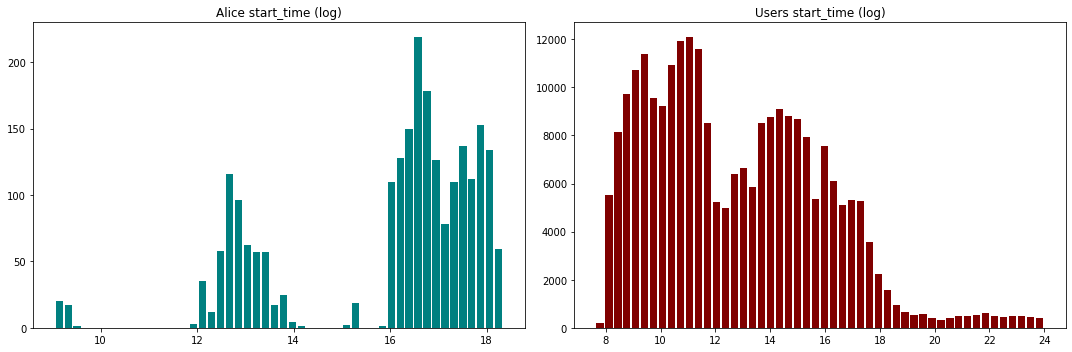

In [26]:
# посещаемость общая

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df[train_df.target == 1].start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df[train_df.target == 0].start_time / 3600, bins=50, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice start_time (log)')
ax[1].title.set_text('Users start_time (log)')
plt.tight_layout()
plt.show()

Очевидной была гипотеза, что Алиса по разному распределена посещаемость интернета в будни и выходные дни, для этого были провдены следующие 2 исследования из которых видно, что в выходные дни, Алиса СОВСЕМ не посещает интернет (данный факт удивил).

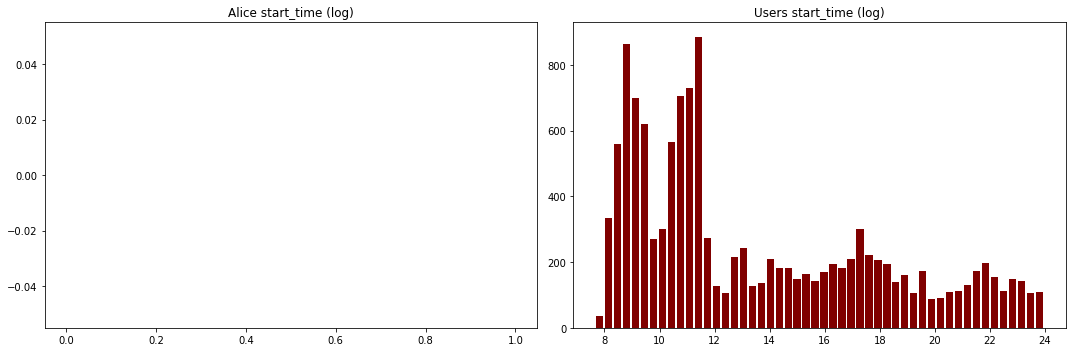

In [27]:
# посещаемость в выходные дни
train_df_temp = train_df[(train_df.weekday >= 5) & (train_df.weekday <= 6)]

train_df_temp_Alice = train_df_temp[train_df_temp.target == 1]
train_df_temp_Users = train_df_temp[train_df_temp.target == 0]


fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df_temp_Alice.start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df_temp_Users.start_time / 3600, bins=50, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice start_time (log)')
ax[1].title.set_text('Users start_time (log)')
plt.tight_layout()
plt.show()

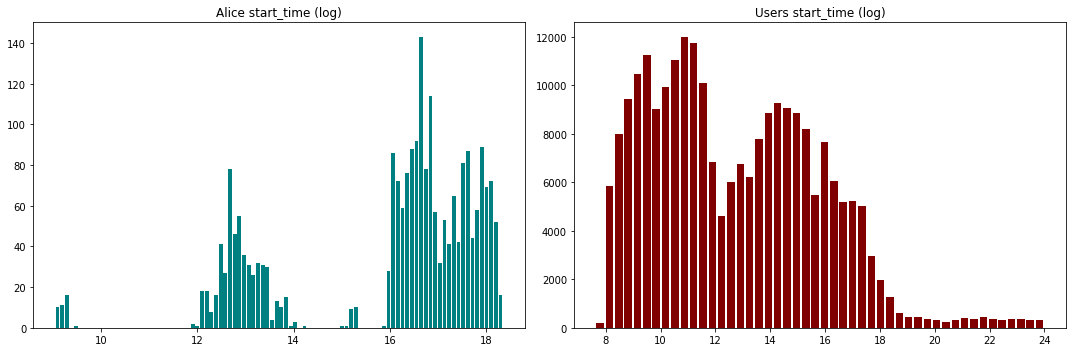

In [28]:
# посещаемость в будни дни
train_df_temp = train_df[(train_df.weekday >= 0) & (train_df.weekday <= 4)]

train_df_temp_Alice = train_df_temp[train_df_temp.target == 1]
train_df_temp_Users = train_df_temp[train_df_temp.target == 0]


fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df_temp_Alice.start_time / 3600, bins=96, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df_temp_Users.start_time / 3600, bins=48, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice start_time (log)')
ax[1].title.set_text('Users start_time (log)')
plt.tight_layout()
plt.show()

Для построения описанных выше графиков любого времени посещения интернет были выделени все 4 группы и построены более близко

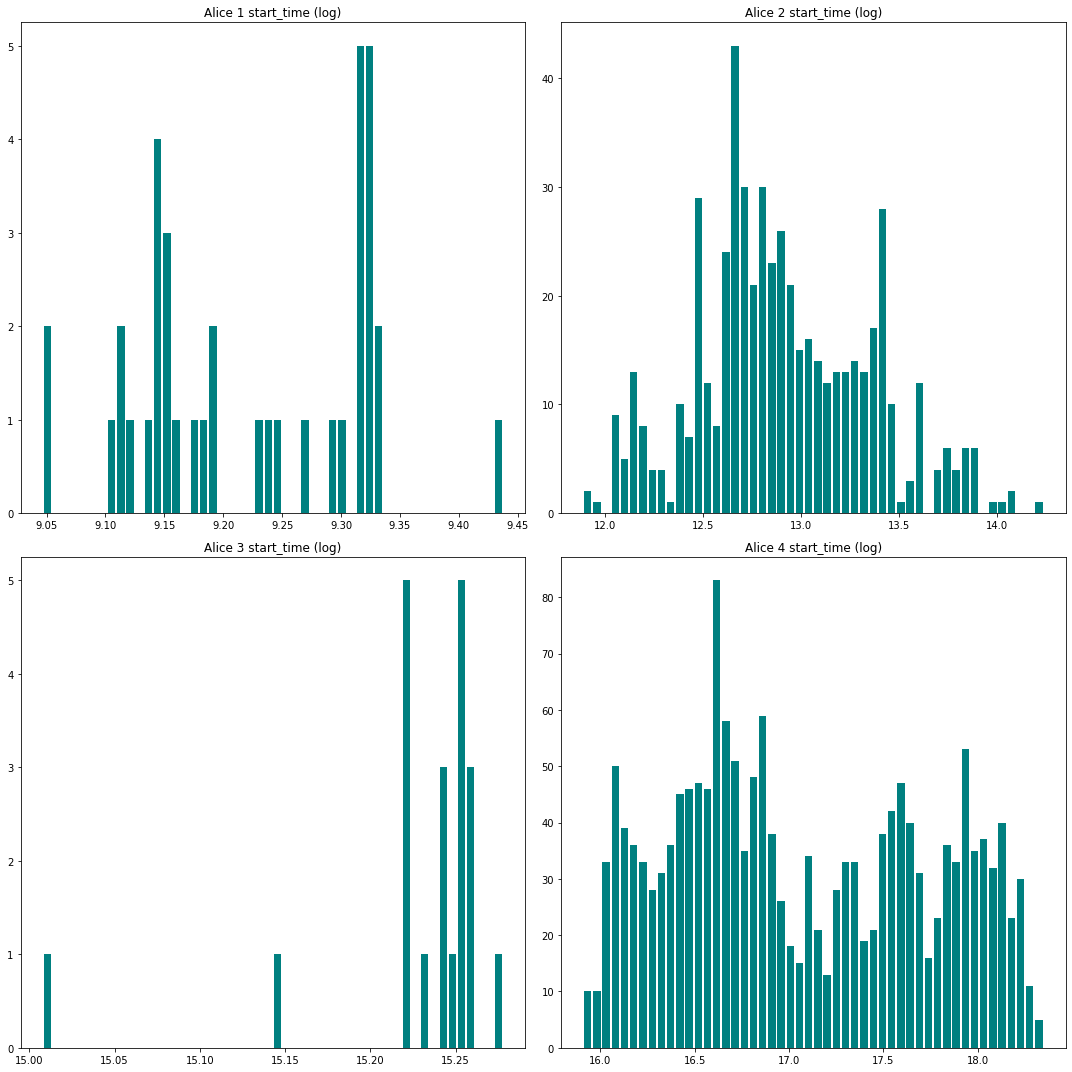

In [29]:
# посещаемость Алисы по временным даиапазонам (только будни дни)
train_df_temp = train_df[(train_df.weekday >= 0) & (train_df.weekday <= 4)]
# разбиение по временным участкам
train_df_temp_1 = train_df_temp[(train_df_temp.start_time/3600 >= 9) & (train_df_temp.start_time/3600 <= 10)]
train_df_temp_2 = train_df_temp[(train_df_temp.start_time/3600 >= 11) & (train_df_temp.start_time/3600 <= 14.5)]
train_df_temp_3 = train_df_temp[(train_df_temp.start_time/3600 >= 15) & (train_df_temp.start_time/3600 <= 15.5)]
train_df_temp_4 = train_df_temp[(train_df_temp.start_time/3600 >= 15.5) & (train_df_temp.start_time/3600 <= 19)]

train_df_temp_Alice_1 = train_df_temp_1[train_df_temp_1.target == 1]
train_df_temp_Alice_2 = train_df_temp_2[train_df_temp_2.target == 1]
train_df_temp_Alice_3 = train_df_temp_3[train_df_temp_3.target == 1]
train_df_temp_Alice_4 = train_df_temp_4[train_df_temp_4.target == 1]

fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0][0].hist(train_df_temp_Alice_1.start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[0][1].hist(train_df_temp_Alice_2.start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[1][0].hist(train_df_temp_Alice_3.start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[1][1].hist(train_df_temp_Alice_4.start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[0][0].title.set_text('Alice 1 start_time (log)')
ax[0][1].title.set_text('Alice 2 start_time (log)')
ax[1][0].title.set_text('Alice 3 start_time (log)')
ax[1][1].title.set_text('Alice 4 start_time (log)')
plt.tight_layout()
plt.show()

При этом, предпочтения по дням недели у Алисы так же разнятся.

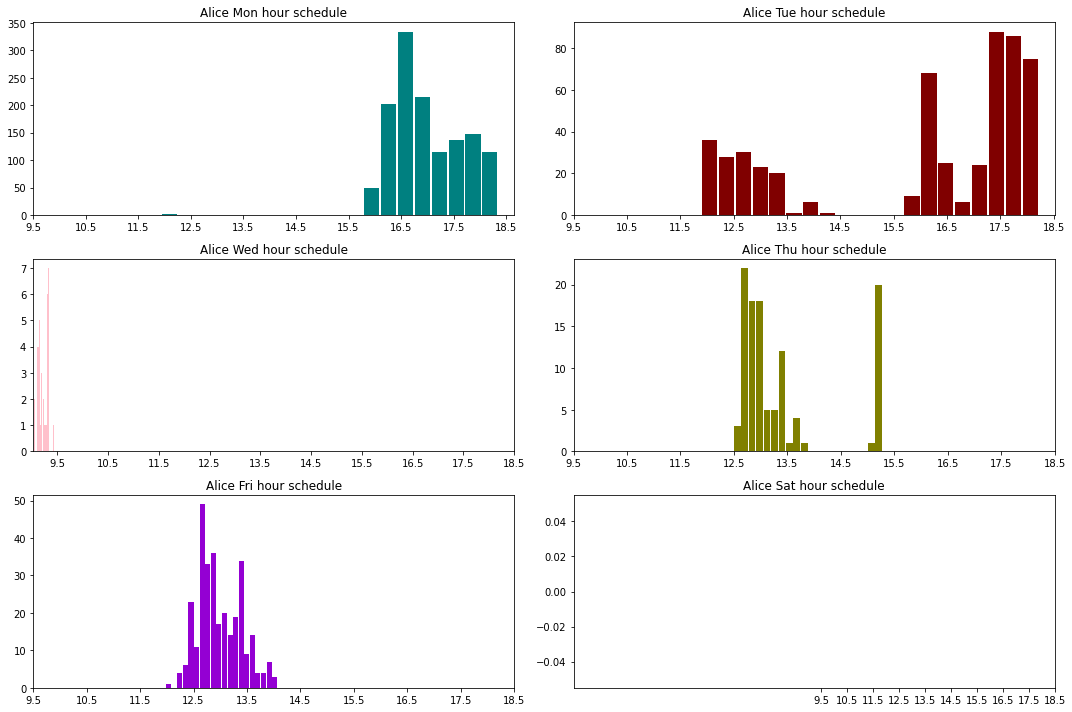

In [30]:
# посещаемость по часам для Алисы по дням недели

Alica = train_df[train_df.target==1]

fig, ax = plt.subplots(3, 2, figsize=(15,10))
ax[0][0].hist(Alica[Alica.weekday==0].start_time / 3600, bins=20, color='teal', label='Mon', rwidth=0.9)
ax[0][1].hist(Alica[Alica.weekday==1].start_time / 3600, bins=20, color='maroon', label='Tue', rwidth=0.9)
ax[1][0].hist(Alica[Alica.weekday==2].start_time / 3600, bins=20, color='pink', label='Wed', rwidth=0.9)
ax[1][1].hist(Alica[Alica.weekday==3].start_time / 3600, bins=20, color='olive', label='Thu', rwidth=0.9)
ax[2][0].hist(Alica[Alica.weekday==4].start_time / 3600, bins=20, color='darkviolet', label='Fri', rwidth=0.9)
ax[2][1].hist(Alica[Alica.weekday==5].start_time / 3600, bins=20, color='blue', label='Sat', rwidth=0.9)

ax[0][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[0][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[1][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[1][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[2][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[2][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])

ax[0][0].title.set_text('Alice Mon hour schedule')
ax[0][1].title.set_text('Alice Tue hour schedule')
ax[1][0].title.set_text('Alice Wed hour schedule')
ax[1][1].title.set_text('Alice Thu hour schedule')
ax[2][0].title.set_text('Alice Fri hour schedule')
ax[2][1].title.set_text('Alice Sat hour schedule')

plt.tight_layout()
plt.show()

Посещаемость по дням недели, так же различается с обычными пользователями, здесь можем выделить 5 дней (будни)

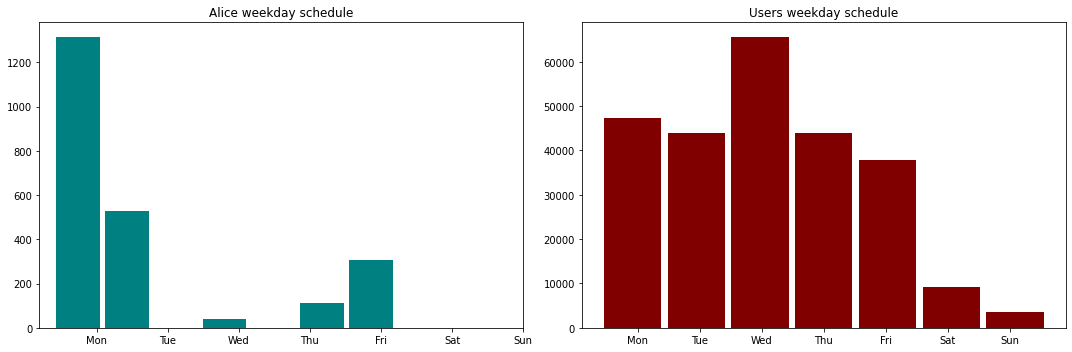

In [31]:
# посещаемость по дням недели
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df[train_df.target==1].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_df[train_df.target==0].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice weekday schedule')
ax[1].title.set_text('Users weekday schedule')
plt.tight_layout()
plt.show()

Следующим параметр, который исследовался - был месяц, и на первый взгляд, разницы почти никакой нет, но это будет исследовано далее более подробно

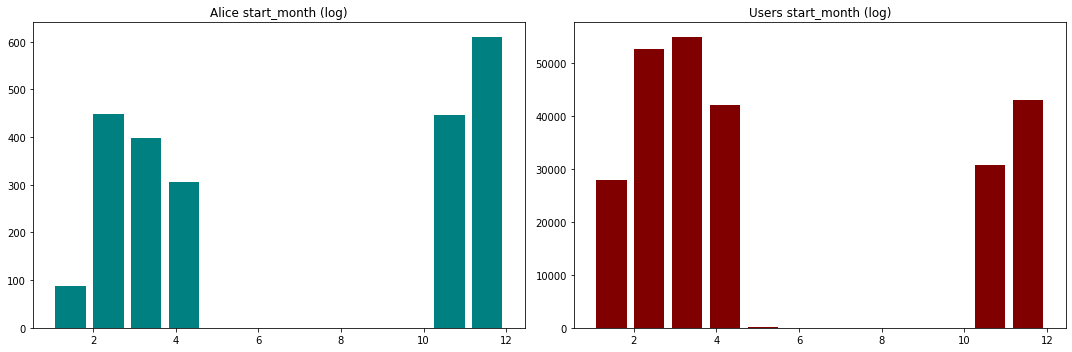

In [32]:
# посещаемость по месяцам

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df[train_df.target == 1].start_month, bins=12, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df[train_df.target == 0].start_month, bins=12, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice start_month (log)')
ax[1].title.set_text('Users start_month (log)')
plt.tight_layout()
plt.show()

###  Иследование поведения на временом интервале и "годов"

Дальше была мысль построить всё это в хоронологическом интервали, и здесь уже начали вырисовываться интересные моменты

Во первых, можем видеть явное различие между популярными днями в 2013 и 2014 году, если с понедельником всё стабильно, то вот все остальные дни уже отличаются, особенно пятница

*Безусловно, как мы выясним дальше, выборка имеет ограниченный промежуток времени и не может иметь точное описание года + имеет переход через НГ, но всё равно, данные очень интересны

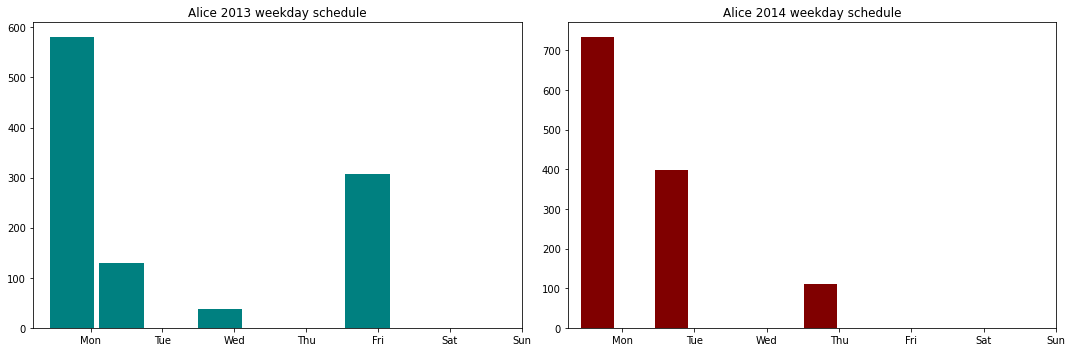

In [33]:
# посещаемость по годам на обучающей выборке для Алисы
fig, ax = plt.subplots(1, 2, figsize=(15,5))
Alica = train_df[train_df.target==1]
Alica_2013 = Alica[Alica.start_year == 2013]
Alica_2014 = Alica[Alica.start_year == 2014]
ax[0].hist(Alica_2013.weekday, bins=7, color='teal', label='Alice 2013', rwidth=0.9)
ax[1].hist(Alica_2014.weekday, bins=7, color='maroon', label='Alice 2014', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice 2013 weekday schedule')
ax[1].title.set_text('Alice 2014 weekday schedule')
plt.tight_layout()
plt.show()

Для обычных пользователей никаких очевидных различий не замечено.

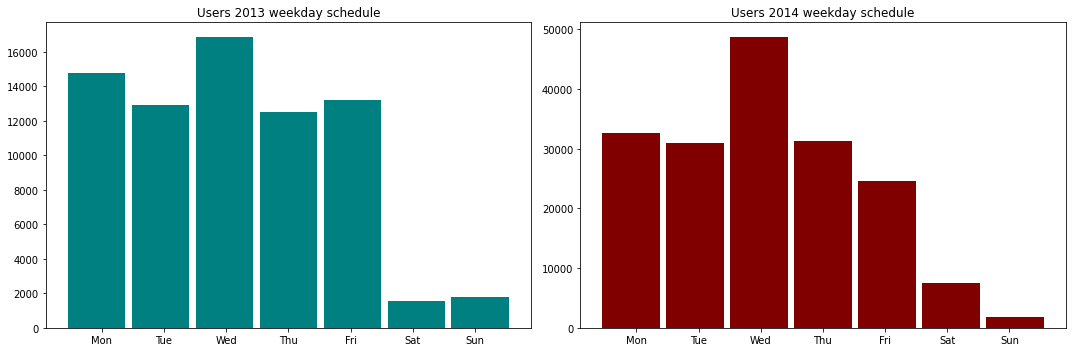

In [34]:
# посещаемость по годам на обучающей выборке для пользователей
fig, ax = plt.subplots(1, 2, figsize=(15,5))
Users = train_df[train_df.target==0]
Users_2013 = Users[Users.start_year == 2013]
Users_2014 = Users[Users.start_year == 2014]
ax[0].hist(Users_2013.weekday, bins=7, color='teal', label='Users 2013', rwidth=0.9)
ax[1].hist(Users_2014.weekday, bins=7, color='maroon', label='Users 2014', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Users 2013 weekday schedule')
ax[1].title.set_text('Users 2014 weekday schedule')
plt.tight_layout()
plt.show()

А вот дальнейший факт уже очень интересен - в тестовой выборке НЕТ 2013-го года!!

Первым предположением будет то, что мы можем добавить номер года для обучения (разбив его на 2 поля), но это сильно ухудшило результаты на тестовой выборке. Так же есть мысли, что можно из обучения вообще выкинуть 2013-ый год, но смею предположить, что результат будет аналогичен и делать так не стоит. В причинах разберёмся далее.

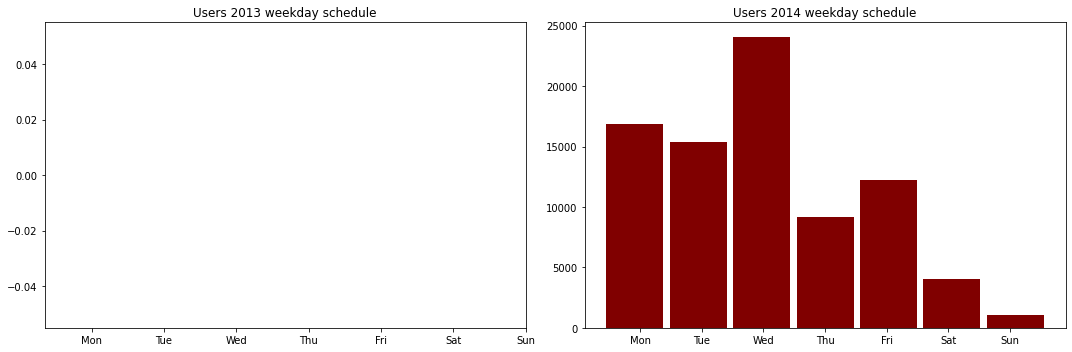

In [35]:
# посещаемость по годам на тестовой выборке для пользователей
fig, ax = plt.subplots(1, 2, figsize=(15,5))
Users = test_df
Users_2013 = Users[Users.start_year == 2013]
Users_2014 = Users[Users.start_year == 2014]
ax[0].hist(Users_2013.weekday, bins=7, color='teal', label='Users 2013', rwidth=0.9)
ax[1].hist(Users_2014.weekday, bins=7, color='maroon', label='Users 2014', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Users 2013 weekday schedule')
ax[1].title.set_text('Users 2014 weekday schedule')
plt.tight_layout()
plt.show()

Посещаемость по часам для каждого года отличается не сильно, так что данный фактор отбрасываем

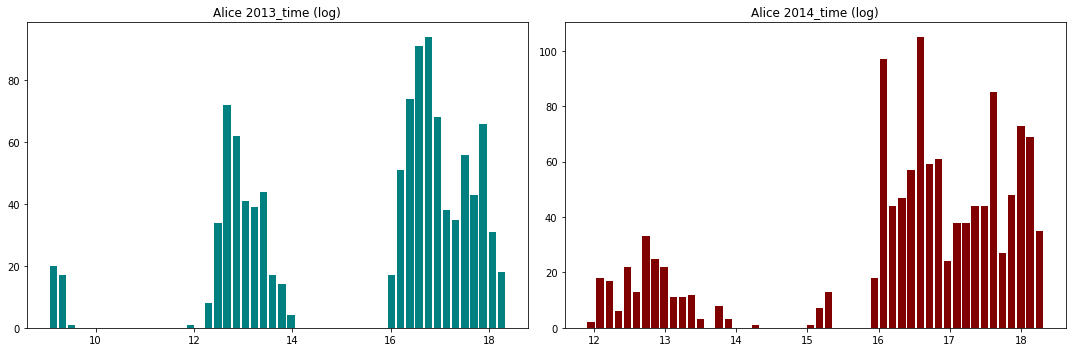

In [36]:
# посещаемость по годам на обучающей выборке для Алисы
fig, ax = plt.subplots(1, 2, figsize=(15,5))
Alica = train_df[train_df.target==1]
Alica_2013 = Alica[Alica.start_year == 2013]
Alica_2014 = Alica[Alica.start_year == 2014]
ax[0].hist(Alica_2013.start_time / 3600, bins=50, color='teal', label='Alice 2013', rwidth=0.8)
ax[1].hist(Alica_2014.start_time / 3600, bins=50, color='maroon', label='Alice 2014', rwidth=0.8)
ax[0].title.set_text('Alice 2013_time (log)')
ax[1].title.set_text('Alice 2014_time (log)')
plt.tight_layout()
plt.show()

Выборки для Алисы по годам так же соизмеримы

In [37]:
# для опыта, а сколько посещений Алисы в каждом году

Alica = train_df[train_df.target==1]
Alica_2013 = Alica[Alica.start_year == 2013]
Alica_2014 = Alica[Alica.start_year == 2014]
print(len(Alica_2013))
print(len(Alica_2014))

1056
1241


У пользователей явных различий в посещении тоже не имеется

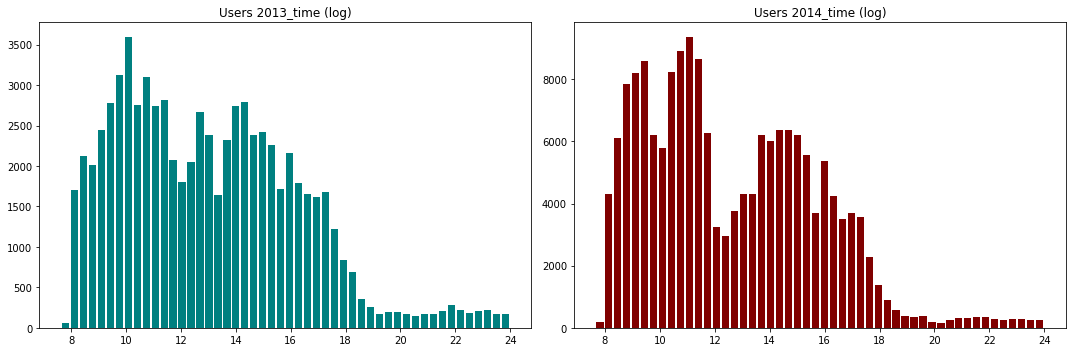

In [38]:
# посещаемость по годам на обучающей выборке для пользователей
fig, ax = plt.subplots(1, 2, figsize=(15,5))
Users = train_df[train_df.target==0]
Users_2013 = Users[Users.start_year == 2013]
Users_2014 = Users[Users.start_year == 2014]
ax[0].hist(Users_2013.start_time / 3600, bins=50, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(Users_2014.start_time / 3600, bins=50, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Users 2013_time (log)')
ax[1].title.set_text('Users 2014_time (log)')
plt.tight_layout()
plt.show()

### Разбитие в хронологическом порядке
А вот дальше возникла мысль, разбить данные в хронологическом порядке по месяцам и посмотреть предпочтения Алисы

Для начала мы изучим месяца, которые представлены в выборках.

И тут получаем следующием месяца на учебной выборке

11 - 12 - 1 - 2 - 3 - 4

и следующием месяцы на тестовой (ХХ - нет месяца)

ХХ - ХХ - 1 - 2 - 3 - 4 - 5

Таким образом, мы обучаемся на 6 месяцах (пол года), по ним проверяем 4 месяца из этого же периода + 1 месяц прогнозируем, которого нет в нашей выборке*. А значит, напрямую использвовать месяца нельзя, так как у нас нет 5-го месяца и его коэффициенты будут занулены.

*Точнее в 5-ом месяце имеется 87 значений, и все они без Алисы, так что добавление месяца портит результаты.

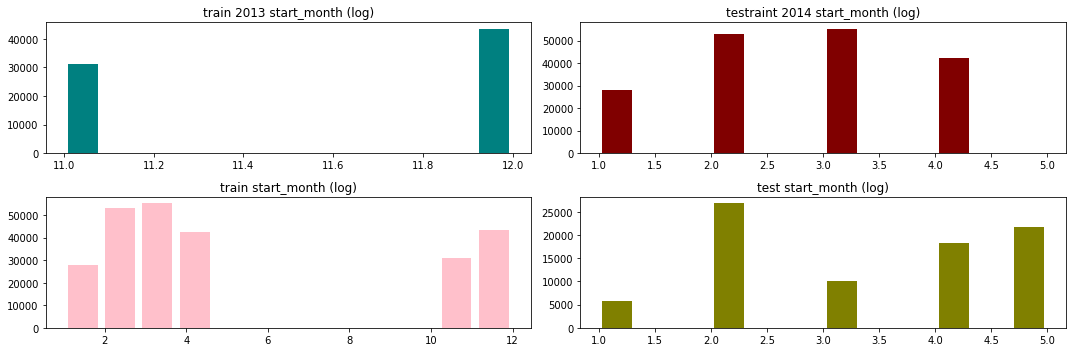

In [39]:
# посещаемость по месяцам между обучением и тестом

fig, ax = plt.subplots(2, 2, figsize=(15,5))
ax[0][0].hist(train_df[train_df.start_year == 2013].start_month, bins=12, color='teal', label='train', rwidth=0.8)
ax[0][1].hist(train_df[train_df.start_year == 2014].start_month, bins=12, color='maroon', label='test', rwidth=0.8)
ax[1][0].hist(train_df.start_month, bins=12, color='pink', label='train', rwidth=0.8)
ax[1][1].hist(test_df.start_month, bins=12, color='olive', label='test', rwidth=0.8)
ax[0][0].title.set_text('train 2013 start_month (log)')
ax[0][1].title.set_text('testraint 2014 start_month (log)')
ax[1][0].title.set_text('train start_month (log)')
ax[1][1].title.set_text('test start_month (log)')
plt.tight_layout()
plt.show()

Дальше изучались предпочтения Алисы по дням недели в каждом месяце на учебной выборке с попыткой выявить что-то интересное.
Здесь стоит отметить, что в 2014-ом году Алиса ни разу не посещала интеренет в пяницу, да и в целом, в пятницу она была только в 11 месяце 2013-го года, после её любимый день сместился на понедельник, остальные же дни - колеблются и сказать что либо чётко по ним, пока что мы не можем.
Распределение у обычных пользователей достаточно стабильно.

#### Очень интересный факт 
####  Пробовал выкинуть 2013-11 (когда алиса "любила" пятницу) из train_df в итоге точность тестового прогноза падает, вероятно это связано с уменьшением числа данных при обучении, так что напрямую выкидывать - не стоит.

Вероятно, в данных имеются какие-то аномалии, раз этот месяц так выделяется.

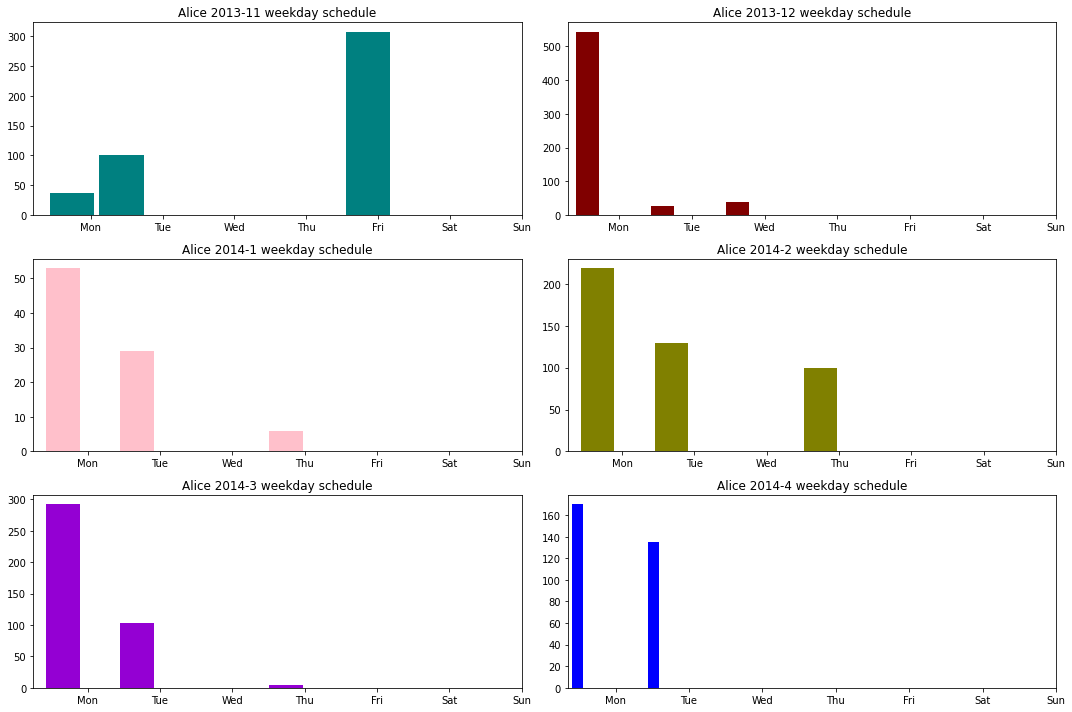

In [40]:
# посещаемость по дням недели для Алисы

Alica = train_df[train_df.target==1]
Alica_2013 = Alica[Alica.start_year == 2013]
Alica_2014 = Alica[Alica.start_year == 2014]

fig, ax = plt.subplots(3, 2, figsize=(15,10))
ax[0][0].hist(Alica_2013[Alica_2013.start_month==11].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[0][1].hist(Alica_2013[Alica_2013.start_month==12].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[1][0].hist(Alica_2014[Alica_2014.start_month==1].weekday, bins=7, color='pink', label='Alice', rwidth=0.9)
ax[1][1].hist(Alica_2014[Alica_2014.start_month==2].weekday, bins=7, color='olive', label='Users', rwidth=0.9)
ax[2][0].hist(Alica_2014[Alica_2014.start_month==3].weekday, bins=7, color='darkviolet', label='Alice', rwidth=0.9)
ax[2][1].hist(Alica_2014[Alica_2014.start_month==4].weekday, bins=7, color='blue', label='Users', rwidth=0.9)

ax[0][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[2][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[2][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])

ax[0][0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0][1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1][0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1][1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[2][0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[2][1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


ax[0][0].title.set_text('Alice 2013-11 weekday schedule')
ax[0][1].title.set_text('Alice 2013-12 weekday schedule')
ax[1][0].title.set_text('Alice 2014-1 weekday schedule')
ax[1][1].title.set_text('Alice 2014-2 weekday schedule')
ax[2][0].title.set_text('Alice 2014-3 weekday schedule')
ax[2][1].title.set_text('Alice 2014-4 weekday schedule')

plt.tight_layout()
plt.show()

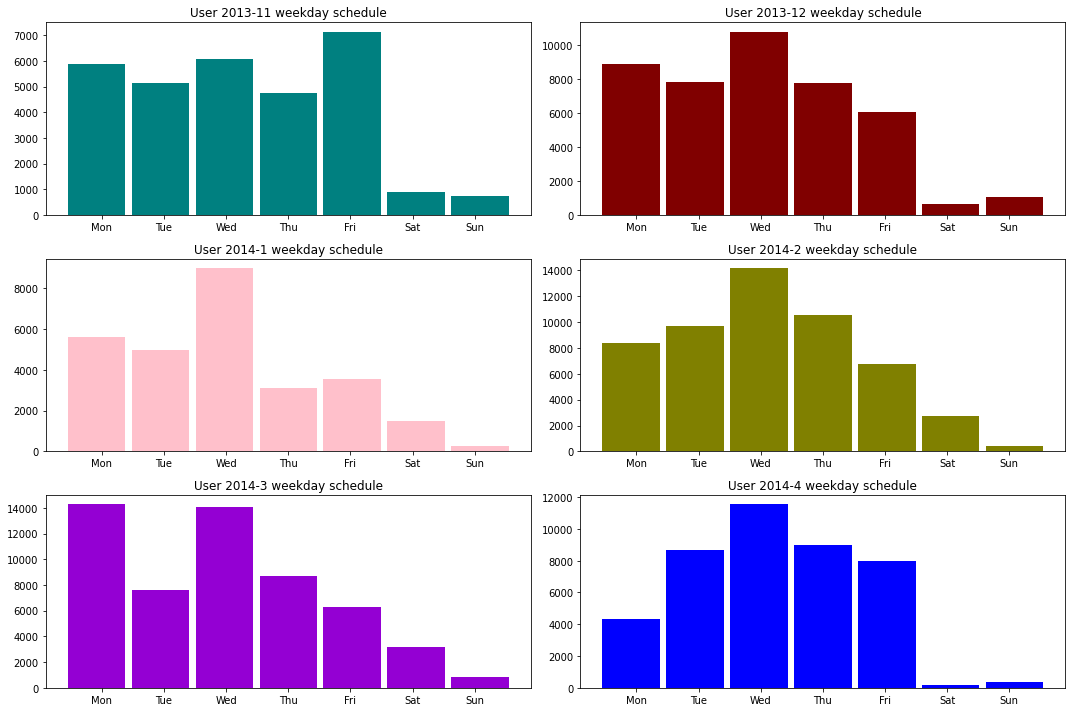

In [41]:
# посещаемость по дням недели для других пользователей (для проверки аномальности данных)

User = train_df[train_df.target==0]
User_2013 = User[User.start_year == 2013]
User_2014 = User[User.start_year == 2014]

fig, ax = plt.subplots(3, 2, figsize=(15,10))
ax[0][0].hist(User_2013[User_2013.start_month==11].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[0][1].hist(User_2013[User_2013.start_month==12].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[1][0].hist(User_2014[User_2014.start_month==1].weekday, bins=7, color='pink', label='Alice', rwidth=0.9)
ax[1][1].hist(User_2014[User_2014.start_month==2].weekday, bins=7, color='olive', label='Users', rwidth=0.9)
ax[2][0].hist(User_2014[User_2014.start_month==3].weekday, bins=7, color='darkviolet', label='Alice', rwidth=0.9)
ax[2][1].hist(User_2014[User_2014.start_month==4].weekday, bins=7, color='blue', label='Users', rwidth=0.9)

ax[0][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[2][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[2][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])

ax[0][0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0][1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1][0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1][1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[2][0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[2][1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


ax[0][0].title.set_text('User 2013-11 weekday schedule')
ax[0][1].title.set_text('User 2013-12 weekday schedule')
ax[1][0].title.set_text('User 2014-1 weekday schedule')
ax[1][1].title.set_text('User 2014-2 weekday schedule')
ax[2][0].title.set_text('User 2014-3 weekday schedule')
ax[2][1].title.set_text('User 2014-4 weekday schedule')

plt.tight_layout()
plt.show()

Изучение предпочтений Алисы по времени посещений между месяцами явных различий не дало.
Разве что точно так же выделяется 2013-11, тем что Алиса в этом месяце больше любила обеденное время, нежели вечернее, как это было после.

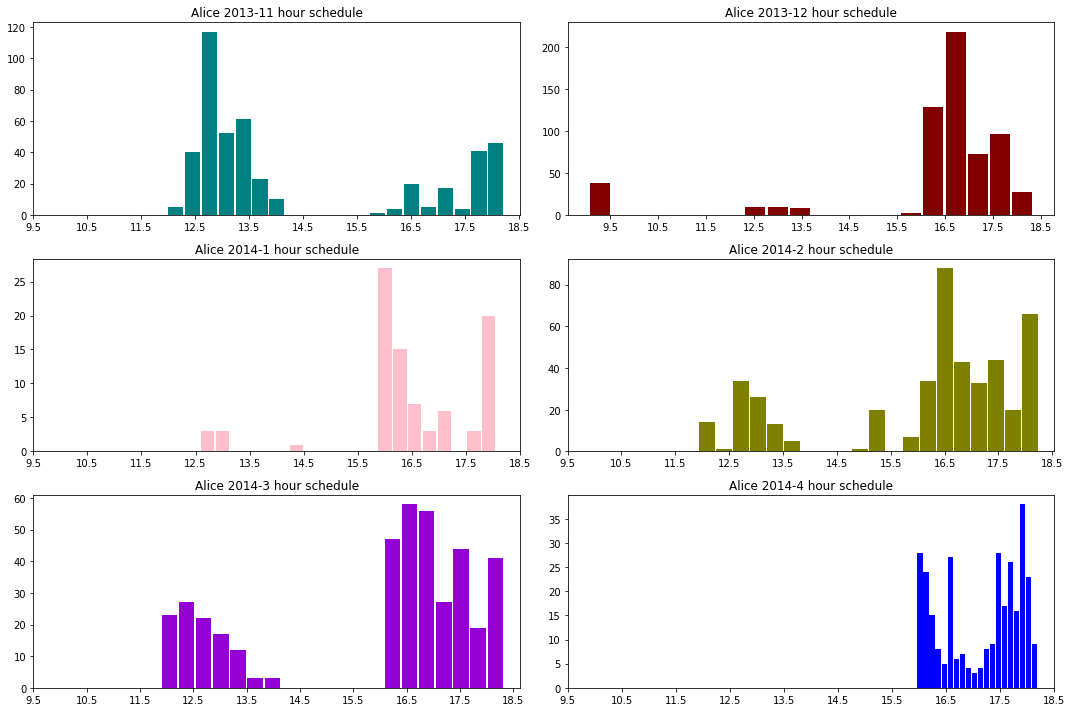

In [42]:
# посещаемость по часам для Алисы по месяцам

Alica = train_df[train_df.target==1]
Alica_2013 = Alica[Alica.start_year == 2013]
Alica_2014 = Alica[Alica.start_year == 2014]

fig, ax = plt.subplots(3, 2, figsize=(15,10))
ax[0][0].hist(Alica_2013[Alica_2013.start_month==11].start_time / 3600, bins=20, color='teal', label='Alice', rwidth=0.9)
ax[0][1].hist(Alica_2013[Alica_2013.start_month==12].start_time / 3600, bins=20, color='maroon', label='Users', rwidth=0.9)
ax[1][0].hist(Alica_2014[Alica_2014.start_month==1].start_time / 3600, bins=20, color='pink', label='Alice', rwidth=0.9)
ax[1][1].hist(Alica_2014[Alica_2014.start_month==2].start_time / 3600, bins=20, color='olive', label='Users', rwidth=0.9)
ax[2][0].hist(Alica_2014[Alica_2014.start_month==3].start_time / 3600, bins=20, color='darkviolet', label='Alice', rwidth=0.9)
ax[2][1].hist(Alica_2014[Alica_2014.start_month==4].start_time / 3600, bins=20, color='blue', label='Users', rwidth=0.9)

ax[0][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[0][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[1][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[1][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[2][0].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])
ax[2][1].set_xticks(ticks=[i - 0.5 for i in np.linspace(10,19,10)])

ax[0][0].title.set_text('Alice 2013-11 hour schedule')
ax[0][1].title.set_text('Alice 2013-12 hour schedule')
ax[1][0].title.set_text('Alice 2014-1 hour schedule')
ax[1][1].title.set_text('Alice 2014-2 hour schedule')
ax[2][0].title.set_text('Alice 2014-3 hour schedule')
ax[2][1].title.set_text('Alice 2014-4 hour schedule')

plt.tight_layout()
plt.show()

### Изучение сессий и их характера
Короткий вывод - мы имеем много посещений по 10 сайтов, при дальнейшем анализе мы увидим, что 10 - это одна и та же сессия, которая просто продолжается.

*Для данных исследований обязательна сортировать в хоронологическом порядке и так же стоит выделить 1 пользьзователя, как мы можем сделать для Алисы

На первом этапе строилось количество посещённых сайтов в каждой выборке. Здесь чётко выделяется то, что почти везде их 10

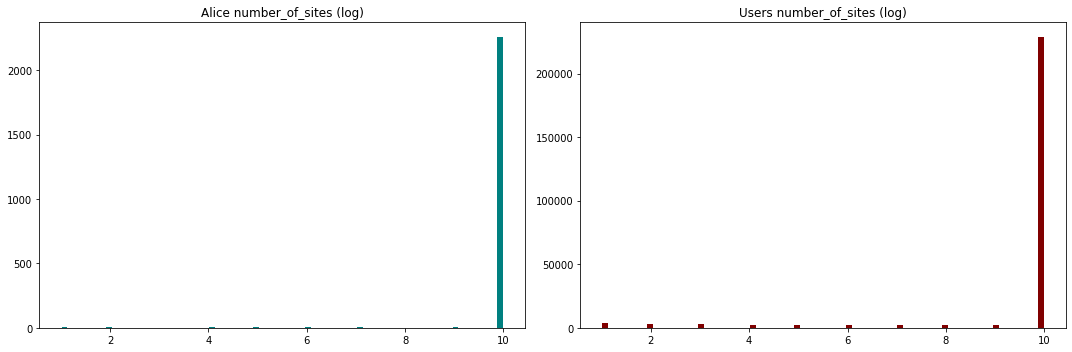

In [43]:
# распределение количества посещений

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df[train_df.target == 1].number_of_sites, bins=60, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df[train_df.target == 0].number_of_sites, bins=60, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice number_of_sites (log)')
ax[1].title.set_text('Users number_of_sites (log)')
plt.tight_layout()
plt.show()

In [44]:
mean_number_of_sites_Alica = train_df[train_df.target == 1].number_of_sites.mean()
mean_number_of_sites_Users = train_df[train_df.target == 0].number_of_sites.mean()
median_number_of_sites_Alica = train_df[train_df.target == 1].number_of_sites.median()
median_number_of_sites_Users = train_df[train_df.target == 0].number_of_sites.median()
print("mean Alica=", mean_number_of_sites_Alica, "mean Users=", mean_number_of_sites_Users)
print("median Alica=", median_number_of_sites_Alica, "median Users=", median_number_of_sites_Users)

mean Alica= 9.912494558119286 mean Users= 9.512349560621498
median Alica= 10.0 median Users= 10.0


##### Для более подробного изучения каждой сессии они были выписаны за январь (так как там мало посещений Алисы)
Здесь можем видеть причину, по которой наиболее популярны сессии с количеством сайтов = "10":
#### "Каждая сессия разбита на выборки по 10 сайтов!"

Например, первое посещение Алисы в январе было 14-го января в 15:54 и закончилось оно в этот же день в 16:04 (здесь мы видим и 9 посещённых сайтов и тот факт, что следующая сессия заметно отличается по времени)

Таким образом можем сделать следующий вывод:

### "Реальное количество сессия значительно меньше, чем представлено в датасете, просто они разбиты на множество мелких по 10 посещений. При этом, датасет специально перемешен, чтобы нельзя было так просто соотнести соседние сессии"

При этом, построение данных в хронологическом порядке не позволяется так просто выделить сессию Алисы, ведь за этот участок времени много других пользователей успело посетить интернет.
Однако после проведении первичного прогноза, мы получаем прогнозные значения "target", по которым уже можно осуществлять исследования тестовых данных. (Но пока что это получается только вручную...)

+Так же была проверена гипотеза, что последний и первый сай соседних выборок будут совпадать (это можно было бы как-то использовать). Однако данная теория была опровергнута

In [45]:
# Выделение сессий Алисы с указанием колличества сайтов, времени первого сайта и номерами первого и последнего сайтов

Alica = train_df[train_df.target==1]
Alica_1 = Alica[Alica.start_month == 1]
for number_sites, time, first_site, finish_site in zip(Alica_1.number_of_sites.values, Alica_1.time1.values,
                                                       Alica_1.site1.values, Alica_1.site10.values):
    print(number_sites, time, first_site, finish_site)

10 2014-01-14T15:54:33.000000000 1 8316
10 2014-01-14T16:03:23.000000000 704 27249
10 2014-01-14T16:03:36.000000000 389 29
10 2014-01-14T16:03:41.000000000 27248 27250
10 2014-01-14T16:03:47.000000000 8316 12619
10 2014-01-14T16:03:50.000000000 448 644
10 2014-01-14T16:03:52.000000000 27250 3000
10 2014-01-14T16:04:01.000000000 12619 99
9 2014-01-14T16:04:12.000000000 704 0
10 2014-01-16T12:35:03.000000000 270 29
10 2014-01-16T12:35:30.000000000 99 3000
10 2014-01-16T12:40:45.000000000 3000 76
10 2014-01-16T12:58:54.000000000 106 29
10 2014-01-16T12:58:57.000000000 76 3000
1 2014-01-16T13:04:20.000000000 3000 0
10 2014-01-20T15:57:42.000000000 270 7832
10 2014-01-20T15:59:14.000000000 30 7832
10 2014-01-20T15:59:28.000000000 29 7832
10 2014-01-20T16:00:29.000000000 29 1517
10 2014-01-20T16:00:52.000000000 1520 1516
10 2014-01-20T16:00:53.000000000 855 1514
10 2014-01-20T16:01:01.000000000 1514 23
10 2014-01-20T16:01:09.000000000 1515 1514
10 2014-01-20T16:01:10.000000000 855 1519
10 20

Более полезной информацией по которой хорошо заметно единство сессий - является длительность каждой из сессий. По ней можем видеть, что прогнозное время представленное в 4-ём столбце очень близко к следующему реальному*.

*Различия обусловленны тем, что мы не знаем длительность последнего сайта и при подобном расчёте принимаем его равным 0. Однако, при необходимости, эту длительность можно рассчитать за счёт определения среднего времени посещения каждого из "любимых Алсиой"  сайтов, что в большинстве случае существенно улучшит прогнозное время.

In [46]:
Alica = train_df[train_df.target==1]
Alica_1 = Alica[Alica.start_month == 1]
for number_sites, time, session_len in zip(Alica_1.number_of_sites.values, Alica_1.time1.values,
                                                       Alica_1.session_len.values):
    print(number_sites, time, session_len, time + int(session_len * 1e9))

10 2014-01-14T15:54:33.000000000 530 2014-01-14T16:03:23.000000000
10 2014-01-14T16:03:23.000000000 13 2014-01-14T16:03:36.000000000
10 2014-01-14T16:03:36.000000000 4 2014-01-14T16:03:40.000000000
10 2014-01-14T16:03:41.000000000 6 2014-01-14T16:03:47.000000000
10 2014-01-14T16:03:47.000000000 3 2014-01-14T16:03:50.000000000
10 2014-01-14T16:03:50.000000000 2 2014-01-14T16:03:52.000000000
10 2014-01-14T16:03:52.000000000 9 2014-01-14T16:04:01.000000000
10 2014-01-14T16:04:01.000000000 11 2014-01-14T16:04:12.000000000
9 2014-01-14T16:04:12.000000000 306 2014-01-14T16:09:18.000000000
10 2014-01-16T12:35:03.000000000 27 2014-01-16T12:35:30.000000000
10 2014-01-16T12:35:30.000000000 16 2014-01-16T12:35:46.000000000
10 2014-01-16T12:40:45.000000000 1089 2014-01-16T12:58:54.000000000
10 2014-01-16T12:58:54.000000000 2 2014-01-16T12:58:56.000000000
10 2014-01-16T12:58:57.000000000 11 2014-01-16T12:59:08.000000000
1 2014-01-16T13:04:20.000000000 0 2014-01-16T13:04:20.000000000
10 2014-01-20T1

###### Дальше приведены факты, которые не имеют какой-то явной пользы.

Если рассматривать длительность сессии по месяцам (да и в целом), то не видно никаких сильно выраженных различий как между месяцами / днями недели, так и с обычным пользователем

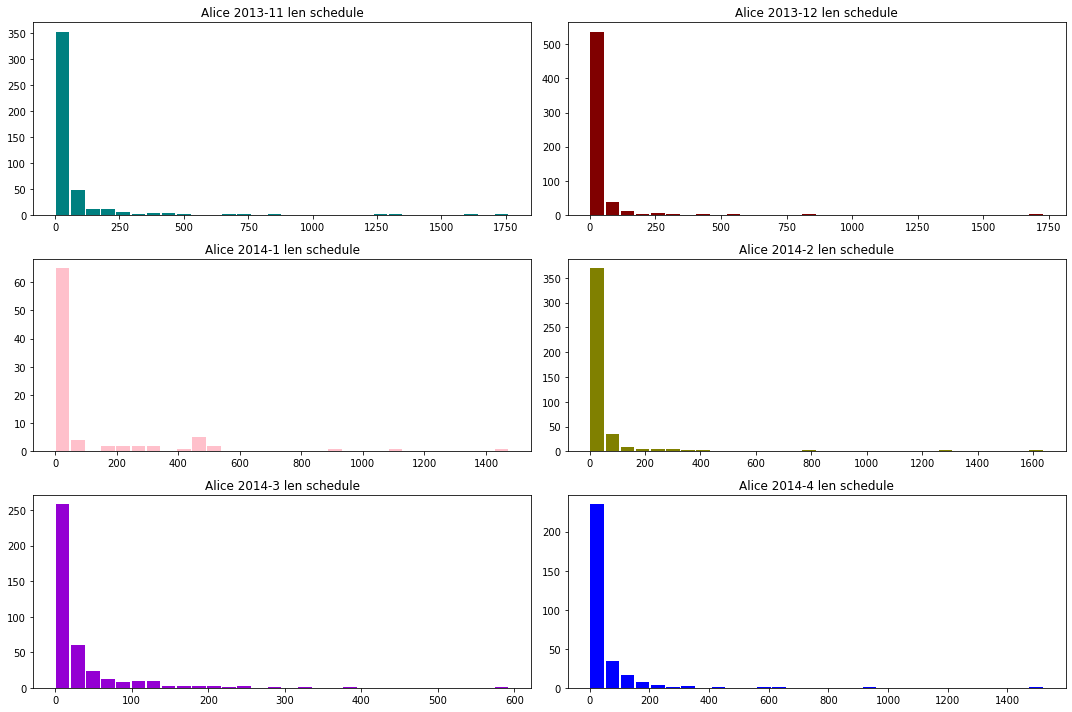

In [47]:
# длительность посещения для Алисы по месяцам

Alica = train_df[train_df.target==1]
Alica_2013 = Alica[Alica.start_year == 2013]
Alica_2014 = Alica[Alica.start_year == 2014]

fig, ax = plt.subplots(3, 2, figsize=(15,10))
ax[0][0].hist(Alica_2013[Alica_2013.start_month==11].session_len, bins=30, color='teal', label='Alice', rwidth=0.9)
ax[0][1].hist(Alica_2013[Alica_2013.start_month==12].session_len, bins=30, color='maroon', label='Users', rwidth=0.9)
ax[1][0].hist(Alica_2014[Alica_2014.start_month==1].session_len, bins=30, color='pink', label='Alice', rwidth=0.9)
ax[1][1].hist(Alica_2014[Alica_2014.start_month==2].session_len, bins=30, color='olive', label='Users', rwidth=0.9)
ax[2][0].hist(Alica_2014[Alica_2014.start_month==3].session_len, bins=30, color='darkviolet', label='Alice', rwidth=0.9)
ax[2][1].hist(Alica_2014[Alica_2014.start_month==4].session_len, bins=30, color='blue', label='Users', rwidth=0.9)

ax[0][0].title.set_text('Alice 2013-11 len schedule')
ax[0][1].title.set_text('Alice 2013-12 len schedule')
ax[1][0].title.set_text('Alice 2014-1 len schedule')
ax[1][1].title.set_text('Alice 2014-2 len schedule')
ax[2][0].title.set_text('Alice 2014-3 len schedule')
ax[2][1].title.set_text('Alice 2014-4 len schedule')

plt.tight_layout()
plt.show()

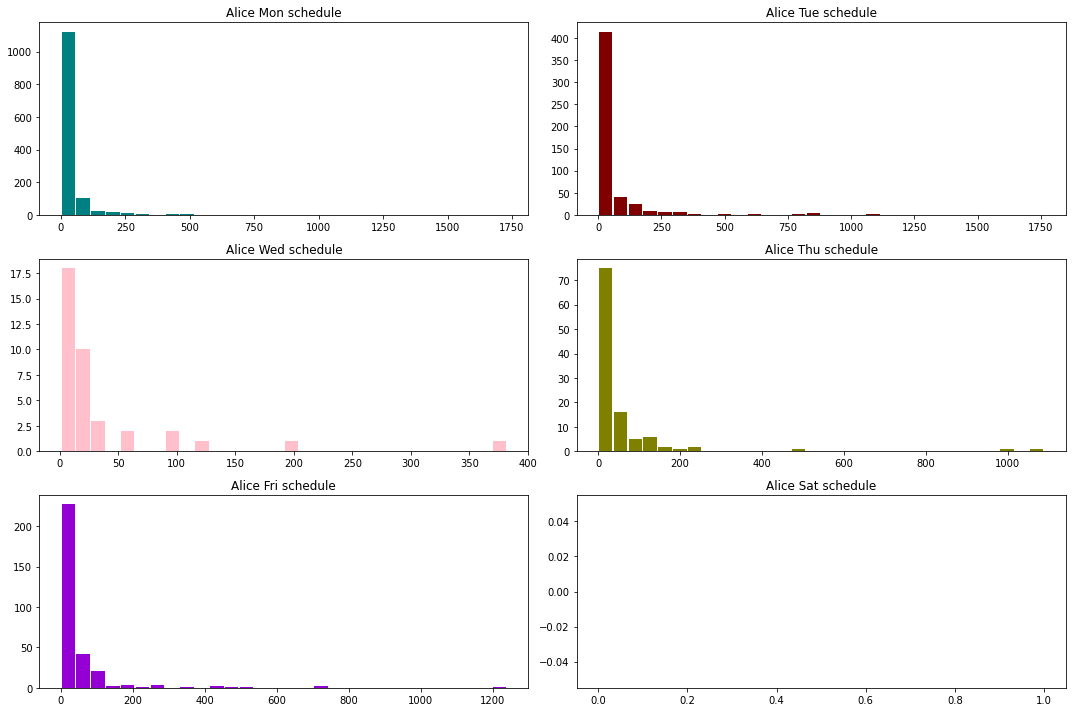

In [48]:
# длительность посещения для Алисы дням недели

Alica = train_df[train_df.target==1]

fig, ax = plt.subplots(3, 2, figsize=(15,10))
ax[0][0].hist(Alica[Alica.weekday==0].session_len, bins=30, color='teal', label='Alice', rwidth=0.9)
ax[0][1].hist(Alica[Alica.weekday==1].session_len, bins=30, color='maroon', label='Users', rwidth=0.9)
ax[1][0].hist(Alica[Alica.weekday==2].session_len, bins=30, color='pink', label='Alice', rwidth=0.9)
ax[1][1].hist(Alica[Alica.weekday==3].session_len, bins=30, color='olive', label='Users', rwidth=0.9)
ax[2][0].hist(Alica[Alica.weekday==4].session_len, bins=30, color='darkviolet', label='Alice', rwidth=0.9)
ax[2][1].hist(Alica[Alica.weekday==5].session_len, bins=30, color='blue', label='Users', rwidth=0.9)

ax[0][0].title.set_text('Alice Mon schedule')
ax[0][1].title.set_text('Alice Tue schedule')
ax[1][0].title.set_text('Alice Wed schedule')
ax[1][1].title.set_text('Alice Thu schedule')
ax[2][0].title.set_text('Alice Fri schedule')
ax[2][1].title.set_text('Alice Sat schedule')

plt.tight_layout()
plt.show()

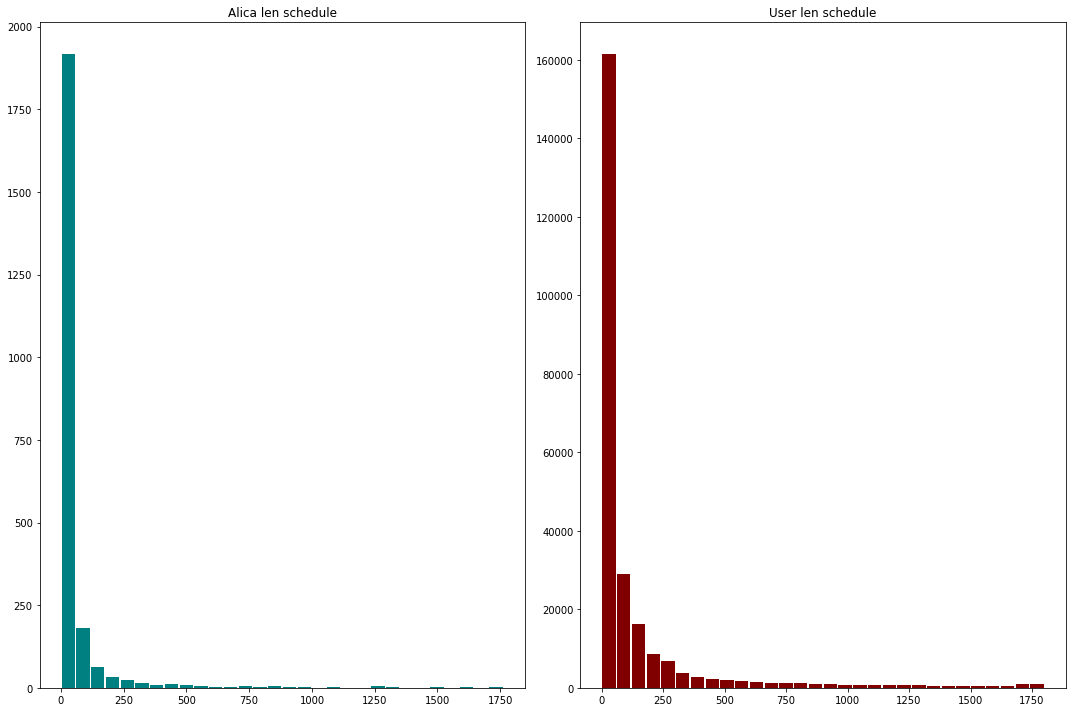

In [49]:
# длительность посещения для Алисы  и обычного пользовтеля

Alica = train_df[train_df.target==1]
User = train_df[train_df.target==0]

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].hist(Alica.session_len, bins=30, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(User.session_len, bins=30, color='maroon', label='Users', rwidth=0.9)

ax[0].title.set_text('Alica len schedule')
ax[1].title.set_text('User len schedule')

plt.tight_layout()
plt.show()

Если же исследовать минуты и секунды - то пользы никакой тоже не наблюдается, что и логично

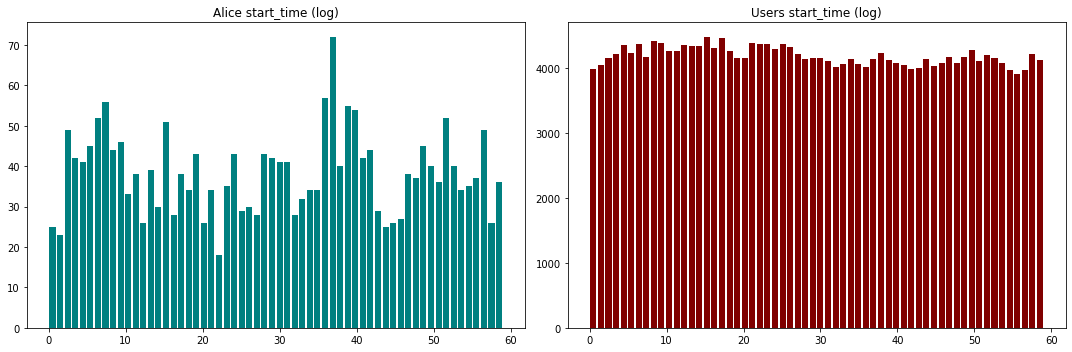

In [50]:
# посещаемость по минутам

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df[train_df.target == 1].start_minute, bins=60, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df[train_df.target == 0].start_minute, bins=60, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice start_time (log)')
ax[1].title.set_text('Users start_time (log)')
plt.tight_layout()
plt.show()

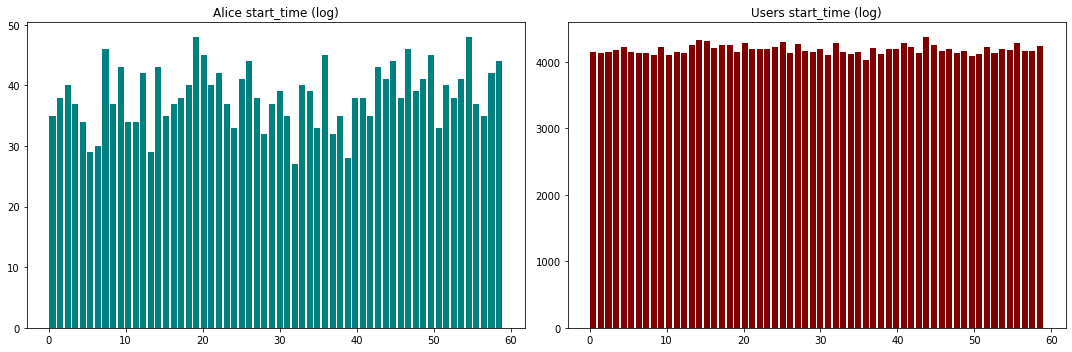

In [51]:
# посещаемость по секундам

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(train_df[train_df.target == 1].start_seconds, bins=60, color='teal', label='Alice', rwidth=0.8)
ax[1].hist(train_df[train_df.target == 0].start_seconds, bins=60, color='maroon', label='Users', rwidth=0.8)
ax[0].title.set_text('Alice start_time (log)')
ax[1].title.set_text('Users start_time (log)')
plt.tight_layout()
plt.show()

# Подготовка данных для обучения моделей

На первом этапе решено оставить 5-ый уровень и 50000 фич, данные параметры подбирались вручную, без перебора гиперпараметров, поэтому очень вероятно, что значения не оптимальны и будут уточнены.

In [11]:
# исходные данные
cv = CountVectorizer(ngram_range=(1, 5), max_features=50000)

Создаём стандартную выборку с помощью "CountVectorizer" где для для обучения данные преобразуются

От этой выборки потом будут идти все дальнейшие исследования

In [12]:
%%time

with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

print(X_train.shape, X_test.shape)

# Обратите внимание на очень большие размеры матриц: 253561 * 50000 = 12678050000 элементов!
# Только разреженные матрицы могут принять это.

(253561, 50000) (82797, 50000)
CPU times: total: 25.8 s
Wall time: 26 s


### Проверка гипотез
*Описание и оценка гипотез приведена до кода

Как мы выяснили ранее, Алиса любит посещать интернет не каждый день, поэтому первым был добавлен параметр характеризующий день недели.
Стоит отметить, что используется не само число, а 7 разных полей, в которых задаётся конкретный день, для того, чтобы модель могла чётко различать их (далее используется аналогичное разбиение).

### (+) Указанная гипотеза дала положительный результат

In [13]:
# день недели разбитый на 7, работает хорошо
# переименовать в 7
def add_week_in_X(X, df):
    Day = np.zeros(shape=(7,len(df)))

    i = 0
    for k in df.weekday:
        Day[k][i] = 1
        i+=1
    
    C_day = csr_matrix(Day.T, dtype=np.int64)

    X_new = hstack((X, C_day))
    return X_new

Для уменьшения требуемых полей, выходные были объединены в 1 поле. Это так же дало небольшой прирост точности поэтому в дальнейшем используется именно этот вариант.

### (+) Указанная гипотеза дала положительный результат

In [13]:
# день недели разбитый на 7, работает хорошо
def add_week_6(X, df):
    Day = np.zeros(shape=(6,len(df)))

    i = 0
    for k in df.weekday:
        if k < 5:
            Day[k][i] = 1
        else:
            Day[5][i] = 1
        i+=1
    
    C_day = csr_matrix(Day.T, dtype=np.int64)

    X_new = hstack((X, C_day))
    return X_new

Как мы могли видеть, в ноябре (11 месяц) Алиса любила пятницу, а потом, вдруг - понедельник, для борьбы с этой гипотизой была осуществленна корректировка пятницы на понедельник. Данное использовалось для проверки гипотезы.

### (-) Указанная гипотеза дала отрицательный результат

In [15]:
# день недели разбитый на 7, с исправленем пятницы в 11 месяце
def add_week_in_X_with_correct_11monht(X, df):
    Day = np.zeros(shape=(7,len(df)))

    i = 0
    for target, start_month, weekday in zip(df.target, df.start_month, df.weekday):
        d = weekday
        if ((target == 1) and (start_month == 11) and (weekday == 4)):
            d = 0
        Day[d][i] = 1
        i+=1
    
    C_day = csr_matrix(Day.T, dtype=np.int64)

    X_new = hstack((X, C_day))
    return X_new

Из исходных данных было выявлено, что Алиса любит посещать интернет в определённые промежутки времени, для этого были использованы значения часа. Как и ожидалось, результат был положительный

### (+) Указанная гипотеза дала положительный результат

In [16]:
# Время дня - улучшает
# переименовать в 24
def add_hour_in_X(X, df):
    hour = np.zeros(shape=(24,len(df)))

    i = 0
    for k in df.start_hour:
        hour[k][i] = 1
        i+=1


    C_hour = csr_matrix(hour.T, dtype=np.int64)

    X_new = hstack((X, C_hour))
    return X_new

Для уменьшения требуемых полей, непосещаемые Алисой часы были объединены в 1 поле. Это так же дало небольшой прирост точности поэтому в дальнейшем используется именно этот вариант.

### (+) Указанная гипотеза дала положительный результат

In [14]:
# Время дня - улучшает
def add_hour_from9to19(X, df):
    hour = np.zeros(shape=(11,len(df)))
    # 9-19 (10 полей) + 1 внешнее (1)

    i = 0
    for k in df.start_hour:
        if (k < 9) or (k >= 19):
            hour[10][i] = 1 # крайнее поле под всё внешнее
        else:
            hour[k-9][i] = 1
        i+=1


    C_hour = csr_matrix(hour.T, dtype=np.int64)

    X_new = hstack((X, C_hour))
    return X_new

Предпринималась попытка разделить временной интервал на меньший шаг - по 15 минут. Однако это, как предполагаем, привело к переобучению.

*Здесь и местами используется 24 часа (и прочие нелинейности), так как описываемые исследования в реальности имели совсем иную хронологию

### (-) Указанная гипотеза дала отрицательный результат

In [18]:
# Время дня по 15 минут
def add_hour_in_15min(X, df):
    hour = np.zeros(shape=(24*4,len(df)))

    i = 0
    for time_second in df.start_time:
        k = int(time_second//900)
        hour[k][i] = 1
        i+=1

    C_hour = csr_matrix(hour.T, dtype=np.int64)

    X_new = hstack((X, C_hour))
    return X_new

Далее временные интервалы были разбиты на 5 участков (4 зоны Алисы и 5-ый, не посещаемый ей участок). Представление булевое 0/1. На удивление, это привело к уменьшению точности, вероятно, всё же требовалась чуть большая точность для выделения каких-то сайтов. Или же исследования были не совсем правильными. или 3-яя зона, слишком невалидна.

В общем, данное разбиение не привело к ожидаемому улучшнию, и за лучший вариант решено принять часовое разбитие в интервале 9-19 часов.

### (-) Указанная гипотеза дала отрицательный результат

In [19]:
# время дня разбитое по секторам Алисы (прямой)
def add_Alica_hour_bool(X, df):
    hour = np.zeros(shape=(5,len(df)))
    
    i = 0
    for start_time in df.start_time:
        if ((start_time/3600 >= 9) & (start_time/3600 <= 9.45)):
            hour[0][i] = 1
        elif ((start_time/3600 >= 11.7) & (start_time/3600 <= 14.3)):
            hour[1][i] = 1
        elif ((start_time/3600 >= 15) & (start_time/3600 <= 15.3)):
            hour[2][i] = 1
        elif ((start_time/3600 >= 15.7) & (start_time/3600 <= 18.5)):
            hour[3][i] = 1
        else:
            hour[4][i] = 1
        i+=1
    
    C_hour = csr_matrix(hour.T, dtype=np.int64)

    X_new = hstack((X, C_hour))
    return X_new

Аналогичное действие, но ещё с разделением по дням недели. Как мы могли видеть, Алиса в определённые дни предпочетает разное время.

Вероятно, это привело к сильному переобучению.


### (-) Указанная гипотеза дала отрицательный результат

In [20]:
# время дня разбитое по секторам Алисы и дням недели
def add_Alica_week_hour_bool(X, df):
    hour = np.zeros(shape=(5*7,len(df)))
    weeks = df.weekday
    start_times = df.start_time
    
    i = 0
    for ind in df.index:
        if ((start_times[ind]/3600 >= 9) & (start_times[ind]/3600 <= 9.45)):
            hour[0+weeks[ind]*5][i] = 1
        elif ((start_times[ind]/3600 >= 11.7) & (start_times[ind]/3600 <= 14.3)):
            hour[1+weeks[ind]*5][i] = 1
        elif ((start_times[ind]/3600 >= 15) & (start_times[ind]/3600 <= 15.3)):
            hour[2+weeks[ind]*5][i] = 1
        elif ((start_times[ind]/3600 >= 15.7) & (start_times[ind]/3600 <= 18.5)):
            hour[3+weeks[ind]*5][i] = 1
        else:
            hour[4+weeks[ind]*5][i] = 1
        i+=1
    
    C_hour = csr_matrix(hour.T, dtype=np.int64)

    X_new = hstack((X, C_hour))
    return X_new

Так же предпринималась попытка добавить нелинейность в исследуемую модель, для этого временные участки были описаны кривой, значение согласно распределению вермени (см. графики каждого участка). Однако это не привело ни к какому улучшению, а лишь ухудшило результат.

Вероятно, местами была слишком малая выборка для корректного описания зависимости. А быть может и сама идеи не заслуживает внимания. Повторимся - цель была в добавлении нелинейности.

### (-) Указанная гипотеза дала отрицательный результат

In [21]:
# время дня разбитое по секторам Алисы (прямой)
def add_Alica_hour_function(X, df):
    hour = np.zeros(shape=(4,len(df)))
    
    i = 0
    for start_time in df.start_time:
        if ((start_time/3600 >= 9) & (start_time/3600 <= 9.45)):
            hour[0][i] = 0.1
####################
        elif ((start_time/3600 >= 11.7) & (start_time/3600 <= 14.3)):
            if ((start_time/3600 >= 11.7) & (start_time/3600 <= 12.5)):
                hour[0][i] = 0.625 * (start_time/3600) - 7.3125
            elif ((start_time/3600 >= 12.5) & (start_time/3600 <= 13)):
                hour[1][i] = 0.5
            elif ((start_time/3600 >= 13) & (start_time/3600 <= 14.3)):
                hour[1][i] = -0.5/1.5 * (start_time/3600) + 7.15 / 1.5
####################
        elif ((start_time/3600 >= 15) & (start_time/3600 <= 15.3)):
            hour[2][i] = 0.05
####################
        elif ((start_time/3600 >= 15.7) & (start_time/3600 <= 18.5)):
            hour[3][i] = 1
        i+=1
    
    C_hour = csr_matrix(hour.T, dtype=np.int64)

    X_new = hstack((X, C_hour))
    return X_new

В конце ноута (Дополнение) описывается обработка сайтов и выделение "Алисиных сайтов" с попыткой зануления иных и/или расчёта рейтинга. Далее приводится различные комбинации использования указанного рейтинга. На обучающей выборке это приводило к 0,99+ точности, однако на тестовой, точность только падала поэтому данная гипотиза после своей проверки не использовалась и перенесена в конец.

Как можем видеть, указанная попытка добавить нелинейность* приводила к сильному переобучению 

*рейтинг был как линеен, так и нелинеен - корень 10-ой степени

### (-) Указанные гипотезы дали отрицательный результат

In [22]:
# Рейтинг всех сайтов сессии
def add_rating_sites(X, df):
    rating = np.zeros(shape=(2,len(df)))
    
    max_rating = max(df.rating_sites)

    i = 0
    for k in df.rating_sites:
        rating[0][i] = k/max_rating
        i+=1


    C_rating = csr_matrix(rating.T, dtype=np.int64)

    X_new = hstack((X, C_rating))
    return X_new

In [23]:
# Рейтинг каждого сайта
def add_rating_All_sites(X, df):
    rating = np.zeros(shape=(10,len(df)))
    
    for z in range(0,10):
        i = 0
        for k in df["rating_site"+str(z+1)]:
            rating[z][i] = k
            i+=1


    C_rating = csr_matrix(rating.T, dtype=np.int64)

    X_new = hstack((X, C_rating))
    return X_new

На начальном этапе так же предпринималась попытка добавить год в качетсве исследуемого параметра, но как могли видеть ранее, в тестовой выборке совсем отсутствует 2013-го года. К тому же, нам приведена последовательность из нескольких месяцев, и разбиение по годам является неуместным.

### (-) Указанные гипотезы дали отрицательный результат

In [24]:
# год разбитый на 2, Добавил с учётом часа - работает почему-то паршиво на тестовой выборке
def add_year(X, df):
    year = np.zeros(shape=(2,len(df)))

    i = 0
    for k in df.start_year:
        if k == 2013:
            print(2013)
        elif k == 2014:
            year[1][i] = 1
        i+=1
    
    C_year = csr_matrix(year.T, dtype=np.int64)

    X_new = hstack((X, C_year))
    return X_new

Из анализа сессий Алисы, мы могли увидеть, что значение в 10 посещённых сайтов в большинстве случаев значит, что это просто продолжение одной и той же сессии. А если мы наблюдаем меньше 10 сайтов, например 7 - то с большой долей вероятности, это окончание исследуемой сессии.

Исходя из этого была выдвинута гипотеза, что Алиса в завершении посещается какой-то особый сайт, или имеются иные особенности.

На удивление, это привело к небольшому увеличению точности
Было  0,952871
Стало 0,95294

### (+) Указанная гипотеза дала положительный результат

In [15]:
# Проверка на последнию сессию (число сайтов меньше 10)
def add_end_session(X, df):
    end_session = np.zeros(shape=(2,len(df)))

    i = 0
    for k in df.number_of_sites:
        if k < 10:
            end_session[0][i] = 1
        else:
            end_session[1][i] = 1
        i+=1


    C_end_session = csr_matrix(end_session.T, dtype=np.int64)

    X_new = hstack((X, C_end_session))
    return X_new

# Добавление новых фич

Оставлены результирующие комбинации, которые приводили к улушению. 

*Названия могут быть слишком громоздки, так как всё это проводилось поэтапно и было целая куча названий.

## Обучающая

In [16]:
X_train_week6 = add_week_6(X_train, train_df)
X_train_week6_hour9to19_Alice = add_hour_from9to19(X_train_week6, train_df)
X_train_week6_hour9to19_endSes_Alice= add_end_session(X_train_week6_hour9to19_Alice, train_df)
X_train_week6_hour9to19_endSes_Alice

<253561x50019 sparse matrix of type '<class 'numpy.int64'>'
	with 4615059 stored elements in Compressed Sparse Row format>

##  Тестовая

In [17]:
X_test_week6 = add_week_6(X_test, test_df)
X_test_week6_hour9to19_Alice = add_hour_from9to19(X_test_week6, test_df)
X_test_week6_hour9to19_endSes_Alice= add_end_session(X_test_week6_hour9to19_Alice, test_df)
X_test_week6_hour9to19_endSes_Alice

<82797x50019 sparse matrix of type '<class 'numpy.int64'>'
	with 1427941 stored elements in Compressed Sparse Row format>

# Использование концепции "сколько Алис рядом"

Как мы могли видеть, одна выборка не является полноценной сессии, для использования этого факта были осуществлены приведённые ниже исследования

На первом этапе мы делали проверку из разряда "Есть ли Алиса рядом", для этого в выборку добавляли поле с предсказанными значениями (y_pred), и если в промежутке +-30 минут от данной сессии находилось более 3-ёх посещений вероятность которых более 0,5, то в ячейку заносилась 1, иначе оставался 0.

### Данная гипотеза дала существенной увеличение точности
0,954048 -> 0,957618

*Перед этим на пороге около 0,954048 было зависание на долгое время

### Описание
Добавлением параметра "Алиса рядам", в теории, может привести к потере устойчивости, так как мы зацикливаем модель саму на себя. Однако данную гипотезу можно рассматривать и как добавление второго слоя, и следствием усложнения модели как раз является повышение точности.


### (+) Указанная гипотеза дала положительный результат

In [44]:
# сперва стоит получить "y_pred_train" и "y_test" в дальнейших расчётах. Здесь приводится примерный алгоритм без запуска.
# Более подробно расписано в "обучение модели"
# подготовка данных "учитель"
y_train = train_df['target'].values
# С=0,1, используется именно этот коэффицент на данном этапе так как даёт большую точность.
lr = LogisticRegression(C=0.5740825670026137, random_state=17, solver='liblinear', max_iter=1000).fit(X_train_week6_hour9to19_endSes_Alice, y_train)

# предсказываются значения
y_pred_train = lr.predict_proba(X_train_week6_hour9to19_endSes_Alice)[:, 1]
y_test = lr.predict_proba(X_test_week6_hour9to19_endSes_Alice)[:, 1]

train_df["y_pred"] = y_pred_train
test_df["y_pred"] = y_test

In [82]:
%%time
# считается 37 минут, нужно быть аккуратнее!

delta = timedelta(minutes=30)
Alice_nearby = np.zeros(shape=(1,len(train_df)))

i = 0
for ind in train_df.index:
    session = train_df.loc[ind]
    temp = train_df[(train_df.session_strt > (session.session_strt - delta))
                   &(train_df.session_strt < (session.session_end  + delta))]
    len_temp_good = len(temp[temp.y_pred > 0.5])
    if len_temp_good>3:
        Alice_nearby[0][i] = 1
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
train_df["Alice_nearby"] = Alice_nearby.T

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
CPU times: total: 37min 16s
Wall time: 37min 19s


In [92]:
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_train.txt", Alice_nearby.T, fmt='%i', delimiter=" ")

In [88]:
# добавляем полученное поле в выборку
C_nearby = csr_matrix(Alice_nearby.T, dtype=np.int64)
X_train_nearby = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby))
X_train_nearby

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4626608 stored elements in Compressed Sparse Row format>

Затем производим аналогичные действия для тестовой выборки

In [34]:
test_df["y_pred"] = y_test

In [101]:
%%time
# 12.5 минут!

delta = timedelta(minutes=30)
Alice_test_nearby = np.zeros(shape=(1,len(test_df)))

i = 0
for ind in test_df.index:
    session = test_df.loc[ind]
    temp = test_df[(test_df.session_strt > (session.session_strt - delta))
                  &(test_df.session_strt < (session.session_end  + delta))]
    len_temp_good = len(temp[temp.y_pred > 0.5])
    if len_temp_good>3:
        Alice_test_nearby[0][i] = 1
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
test_df["Alice_nearby"] = Alice_test_nearby.T

0
10000
20000
30000
40000
50000
60000
70000
80000
CPU times: total: 12min 20s
Wall time: 12min 29s


In [102]:
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_test.txt", Alice_test_nearby.T, fmt='%i', delimiter=" ")

In [104]:
# добавляем полученное поле в выборку
C_nearby = csr_matrix(Alice_test_nearby.T, dtype=np.int64)
X_test_nearby = hstack((X_test_week6_hour9to19_endSes_Alice, C_nearby))
X_test_nearby

<82797x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 1432000 stored elements in Compressed Sparse Row format>

### Этап 2
На втором этае этапе мы делали проверку из разряда "сколько Алис рядом", для этого в промежутке +-30 минут от данной сессии (для корректности сравнений этапов) находилось колличество посещений вероятность которых более 0,5. На данном мы не масштабированное число, что может привести к уменьшению точности, а точнее излишнему влиянию данного факта, вероятно придётся произвести маштабирование.

Увы, даже с нормальизацией, эффект на валидационной выборке был несущественен. Вероятно, потому что численно значение сильно зависит от длительности выборок, поэтому конкретное значение несёт меньше эффекта, чем сам факт наличия искомых выборок рядом.

### (-) Указанная гипотеза дала отрицательный результат

In [106]:
%%time
# считается 37 минут, нужно быть аккуратнее!

delta = timedelta(minutes=30)
Alice_nearby_2 = np.zeros(shape=(1,len(train_df)))

i = 0
for ind in train_df.index:
    session = train_df.loc[ind]
    temp = train_df[(train_df.session_strt > (session.session_strt - delta))
                   &(train_df.session_strt < (session.session_end  + delta))]
    Alice_nearby_2[0][i] = len(temp[temp.y_pred > 0.5])
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
train_df["Alice_nearby_2"] = Alice_nearby_2.T

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
CPU times: total: 37min 47s
Wall time: 37min 50s


In [107]:
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_2_train.txt", Alice_nearby.T, fmt='%i', delimiter=" ")

In [113]:
max(Alice_nearby_2[0])

246.0

Как можем видеть, максимальное значение получилось аж 246 посещений, поэтому проведём нормализацию делением на 250

In [116]:
Alice_nearby_2 = Alice_nearby_2 /250
max(Alice_nearby_2[0])

0.984

In [117]:
# добавляем полученное поле в выборку
C_nearby_2 = csr_matrix(Alice_nearby_2.T, dtype=np.int64)
X_train_nearby_2 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby_2))
X_train_nearby_2

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4634168 stored elements in Compressed Sparse Row format>

# Этап 3 изменяем количество "соседей"

Сперва изучается 1 сосед, вместо 4, точность от данного опыта, к сожалению, снизилась.

*Что и логично, ведь 1 сосед всегда будет, если данная выборка является достаточным кандидатом.


### (-) Указанная гипотеза дала отрицательный результат

In [35]:
%%time
# считается 37 минут, нужно быть аккуратнее!

delta = timedelta(minutes=30)
Alice_nearby = np.zeros(shape=(1,len(train_df)))

i = 0
for ind in train_df.index:
    session = train_df.loc[ind]
    temp = train_df[(train_df.session_strt > (session.session_strt - delta))
                   &(train_df.session_strt < (session.session_end  + delta))]
    len_temp_good = len(temp[temp.y_pred > 0.5])
    if len_temp_good>=1:
        Alice_nearby[0][i] = 1
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
train_df["Alice_nearby"] = Alice_nearby.T

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
CPU times: total: 36min 11s
Wall time: 36min 12s


In [38]:
# Ищется хотя бы 1 сосед
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_3_train.txt", Alice_nearby.T, fmt='%i', delimiter=" ")
# добавляем полученное поле в выборку
C_nearby_3 = csr_matrix(Alice_nearby.T, dtype=np.int64)
X_train_nearby_3 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby_3))
X_train_nearby_3

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4634168 stored elements in Compressed Sparse Row format>

In [36]:
%%time
# 12.5 минут!

delta = timedelta(minutes=30)
Alice_test_nearby = np.zeros(shape=(1,len(test_df)))

i = 0
for ind in test_df.index:
    session = test_df.loc[ind]
    temp = test_df[(test_df.session_strt > (session.session_strt - delta))
                  &(test_df.session_strt < (session.session_end  + delta))]
    len_temp_good = len(temp[temp.y_pred > 0.5])
    if len_temp_good>=1:
        Alice_test_nearby[0][i] = 1
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
test_df["Alice_nearby"] = Alice_test_nearby.T

0
10000
20000
30000
40000
50000
60000
70000
80000
CPU times: total: 10min 29s
Wall time: 10min 29s


In [47]:
# Ищется хотя бы 1 сосед
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_3_test.txt", Alice_test_nearby.T, fmt='%i', delimiter=" ")
# добавляем полученное поле в выборку
C_nearby_3 = csr_matrix(Alice_test_nearby.T, dtype=np.int64)
X_test_nearby_3 = hstack((X_test_week6_hour9to19_endSes_Alice, C_nearby_3))
X_test_nearby_3

<82797x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 1436046 stored elements in Compressed Sparse Row format>

# Этап 4 изменяем порог "соседей"

Меняем 50% на 30%, точность от данного опыта, к сожалению, снизилась


### (-) Указанная гипотеза дала отрицательный результат

In [49]:
%%time
# считается 37 минут, нужно быть аккуратнее!

delta = timedelta(minutes=30)
Alice_nearby = np.zeros(shape=(1,len(train_df)))

i = 0
for ind in train_df.index:
    session = train_df.loc[ind]
    temp = train_df[(train_df.session_strt > (session.session_strt - delta))
                   &(train_df.session_strt < (session.session_end  + delta))]
    len_temp_good = len(temp[temp.y_pred > 0.3])
    if len_temp_good>3:
        Alice_nearby[0][i] = 1
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
train_df["Alice_nearby"] = Alice_nearby.T

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
CPU times: total: 35min 27s
Wall time: 35min 28s


In [53]:
# Ищется хотя бы 1 сосед
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_4_train.txt", Alice_nearby.T, fmt='%i', delimiter=" ")
# добавляем полученное поле в выборку
C_nearby_4 = csr_matrix(Alice_nearby.T, dtype=np.int64)
X_train_nearby_4 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby_4))
X_train_nearby_4

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4632048 stored elements in Compressed Sparse Row format>

In [50]:
%%time
# 12.5 минут!

delta = timedelta(minutes=30)
Alice_test_nearby = np.zeros(shape=(1,len(test_df)))

i = 0
for ind in test_df.index:
    session = test_df.loc[ind]
    temp = test_df[(test_df.session_strt > (session.session_strt - delta))
                  &(test_df.session_strt < (session.session_end  + delta))]
    len_temp_good = len(temp[temp.y_pred > 0.3])
    if len_temp_good>3:
        Alice_test_nearby[0][i] = 1
    if (i)%10000==0:
        print(i)
        #break
    i+=1
    
test_df["Alice_nearby"] = Alice_test_nearby.T

0
10000
20000
30000
40000
50000
60000
70000
80000
CPU times: total: 10min 29s
Wall time: 10min 29s


In [52]:
# Ищется хотя бы 1 сосед
# сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
np.savetxt("Alice_nearby_4_test.txt", Alice_test_nearby.T, fmt='%i', delimiter=" ")
# добавляем полученное поле в выборку
C_nearby_4 = csr_matrix(Alice_test_nearby.T, dtype=np.int64)
X_test_nearby_4 = hstack((X_test_week6_hour9to19_endSes_Alice, C_nearby_4))
X_test_nearby_4

<82797x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 1434794 stored elements in Compressed Sparse Row format>

# Этап 5

Для дальнейших исследований создадим функцию производящую расчёты описанные выше и запустим её на ночь для исследования оптимального колличества соседей, порога и временного разброса.

*Данная функция может иметь множество неоптимальностей, и очень вероятно, время её работы можно существенно сократить.

** В итоге запуск осуществлялсь по отдельно созданному алгоритму, так как использование функции для каждого значения не оптимально и приводит к существенному увеличению времени расчёта.



### (+) Указанная гипотеза дала положительный результат

In [66]:
def neighbors(df, quantity : int, fraction : float, period_minutes : int):
    delta = timedelta(minutes=period_minutes)
    Alice_nearby = np.zeros(shape=(1,len(df)))

    i = 0
    for ind in df.index:
        session = df.loc[ind]
        temp = df[(df.session_strt > (session.session_strt - delta))
                 &(df.session_strt < (session.session_end  + delta))]
        len_temp_good = len(temp[temp.y_pred > fraction])
        if len_temp_good>=quantity:
            Alice_nearby[0][i] = 1
        i+=1

    return Alice_nearby.T

Далее запускаем цикл с перебором интересующих диапазонов
+ по количеству соседей [1, 2, 3, 4, 5, 6, 7, 8, 9]. Выбран большой диапазон, так как проверка имеет максимальную глубину и мало увеличивает сложность вычисления.
+ по доли, от которой соседа можно считать валидной [0.3, 0.4, 0.5, 0.6, 0.7], 0,5+-0,2. Уровень вложенности средний. Добавляет фильтрацию от уже уменьшенного по времени массива, поэтому сложность хоть и возрастает, но не так сильно, как от перебора временных интервалов
+ по временному разбросу [20, 30, 40, 50, 60] минут

Оринетировочное время опыта 5x1,5ч (90минут) = 7,5 часов. 1,5 часа было получено из тестовых пусков до вылета первых ошибок.

### Получилось:
CPU times: total: 7h 34min 21s

Wall time: 8h 51min 55s

In [131]:
%%time

Alice_nearby = np.zeros(shape=(10,5,len(train_df)))

for period_minutes in [20, 30, 40, 50, 60]:
    delta = timedelta(minutes=period_minutes)
    print("period_minutes = " + str(period_minutes))
    i = 0
    for ind in train_df.index:
        session = train_df.loc[ind]
        temp = train_df[(train_df.session_strt > (session.session_strt - delta))
                       &(train_df.session_strt < (session.session_end  + delta))]
        
        f_i=0
        for fraction in [0.3, 0.4, 0.5, 0.6, 0.7]:
            len_temp_good = len(temp[temp.y_pred > fraction])
            q_i=0
            for quantity in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
                if len_temp_good>=quantity:
                    Alice_nearby[q_i][f_i][i] = 1
                q_i+=1
            f_i+=1   
        i+=1
    
    q_i=0
    for quantity in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
        f_i=0
        for fraction in [0.3, 0.4, 0.5, 0.6, 0.7]:
            print("quantity = " + str(quantity) + "| fraction = " + str(fraction) + "| period_minutes = " + str(period_minutes))
            # выделяем нужный массив данных
            train_nearby = Alice_nearby[:][f_i]
            train_nearby = train_nearby[q_i:q_i+1]
            
            # сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
            name = "Alice_nearby"+"_q"+str(quantity)+"_f"+str(fraction)+"_p"+str(period_minutes)+".txt"
            np.savetxt(name, train_nearby.T, fmt='%i', delimiter=" ")
            # добавляем полученное поле в выборку
            C_nearby = csr_matrix(train_nearby.T, dtype=np.int64)
            X_train_temp = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby))
            
            # запускаем модель, для получения данных
            lr = LogisticRegression(C=0.1, random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_temp, y_train)
            cv_scores = cv_get_auc_lr_valid(X_train_temp, y_train, lr)
            print(np.round(cv_scores,4), f'Среднее значение по 10-ти фолдам: {round(cv_scores.mean(),4)}')
            
            f_i+=1
        q_i+=1

period_minutes = 20
quantity = 1| fraction = 0.3| period_minutes = 20
[0.8742 0.9649 0.9949 0.9306 0.9803 0.9941 0.6159 0.9862 0.9957 0.9903] Среднее значение по 10-ти фолдам: 0.9327
quantity = 1| fraction = 0.4| period_minutes = 20
[0.867  0.9691 0.9891 0.9498 0.9841 0.9955 0.6901 0.9895 0.998  0.9906] Среднее значение по 10-ти фолдам: 0.9423
quantity = 1| fraction = 0.5| period_minutes = 20
[0.8656 0.9743 0.9878 0.9617 0.9649 0.9809 0.7244 0.9908 0.9978 0.9912] Среднее значение по 10-ти фолдам: 0.9439
quantity = 1| fraction = 0.6| period_minutes = 20
[0.8525 0.9746 0.9868 0.9566 0.9748 0.9765 0.8281 0.9916 0.9979 0.9926] Среднее значение по 10-ти фолдам: 0.9532
quantity = 1| fraction = 0.7| period_minutes = 20
[0.8483 0.9742 0.9872 0.959  0.9773 0.9761 0.8618 0.9917 0.9949 0.9928] Среднее значение по 10-ти фолдам: 0.9563
quantity = 2| fraction = 0.3| period_minutes = 20
[0.8775 0.9691 0.9957 0.948  0.9875 0.9946 0.6153 0.9909 0.9959 0.9905] Среднее значение по 10-ти фолдам: 0.9365
qu

[0.8788 0.9694 0.9955 0.9455 0.9868 0.9942 0.5744 0.9908 0.9953 0.9914] Среднее значение по 10-ти фолдам: 0.9322
quantity = 2| fraction = 0.4| period_minutes = 30
[0.8739 0.975  0.9969 0.9579 0.9877 0.9822 0.6855 0.9916 0.998  0.9917] Среднее значение по 10-ти фолдам: 0.9441
quantity = 2| fraction = 0.5| period_minutes = 30
[0.8646 0.9739 0.9973 0.9622 0.9726 0.9785 0.8204 0.9922 0.9979 0.9938] Среднее значение по 10-ти фолдам: 0.9553
quantity = 2| fraction = 0.6| period_minutes = 30
[0.8583 0.9735 0.9972 0.9439 0.9738 0.98   0.8693 0.9922 0.9978 0.994 ] Среднее значение по 10-ти фолдам: 0.958
quantity = 2| fraction = 0.7| period_minutes = 30
[0.8479 0.9732 0.9873 0.933  0.9789 0.9804 0.8878 0.9921 0.9982 0.9939] Среднее значение по 10-ти фолдам: 0.9573
quantity = 3| fraction = 0.3| period_minutes = 30
[0.8754 0.9675 0.9967 0.9494 0.9873 0.996  0.76   0.9916 0.9974 0.9921] Среднее значение по 10-ти фолдам: 0.9513
quantity = 3| fraction = 0.4| period_minutes = 30
[0.8737 0.9727 0.997  0

[0.8777 0.9712 0.9971 0.9612 0.9912 0.9756 0.7739 0.9918 0.9967 0.9936] Среднее значение по 10-ти фолдам: 0.953
quantity = 3| fraction = 0.5| period_minutes = 40
[0.8626 0.9721 0.9883 0.9549 0.9753 0.9763 0.8594 0.9924 0.9968 0.9936] Среднее значение по 10-ти фолдам: 0.9572
quantity = 3| fraction = 0.6| period_minutes = 40
[0.8608 0.9688 0.9882 0.9448 0.9785 0.9765 0.8821 0.9925 0.9969 0.9946] Среднее значение по 10-ти фолдам: 0.9584
quantity = 3| fraction = 0.7| period_minutes = 40
[0.856  0.9683 0.988  0.944  0.9792 0.9771 0.8838 0.9913 0.9972 0.9958] Среднее значение по 10-ти фолдам: 0.9581
quantity = 4| fraction = 0.3| period_minutes = 40
[0.869  0.9697 0.9968 0.9452 0.9913 0.9772 0.8226 0.9917 0.9967 0.9946] Среднее значение по 10-ти фолдам: 0.9555
quantity = 4| fraction = 0.4| period_minutes = 40
[0.8731 0.973  0.988  0.9532 0.9918 0.9779 0.8248 0.9922 0.9969 0.9944] Среднее значение по 10-ти фолдам: 0.9565
quantity = 4| fraction = 0.5| period_minutes = 40
[0.8478 0.9694 0.9878 0

[0.8417 0.9734 0.988  0.9299 0.9794 0.9756 0.8574 0.9924 0.9966 0.9955] Среднее значение по 10-ти фолдам: 0.953
quantity = 4| fraction = 0.6| period_minutes = 50
[0.8383 0.9727 0.9883 0.9288 0.982  0.9723 0.8647 0.9928 0.9967 0.9954] Среднее значение по 10-ти фолдам: 0.9532
quantity = 4| fraction = 0.7| period_minutes = 50
[0.8449 0.9725 0.988  0.9332 0.9816 0.9763 0.8626 0.9927 0.9969 0.9956] Среднее значение по 10-ти фолдам: 0.9544
quantity = 5| fraction = 0.3| period_minutes = 50
[0.861  0.9743 0.9963 0.9406 0.9912 0.9713 0.8065 0.992  0.9967 0.9944] Среднее значение по 10-ти фолдам: 0.9524
quantity = 5| fraction = 0.4| period_minutes = 50
[0.8524 0.9748 0.9877 0.9372 0.9915 0.9736 0.8538 0.9927 0.9964 0.9948] Среднее значение по 10-ти фолдам: 0.9555
quantity = 5| fraction = 0.5| period_minutes = 50
[0.8426 0.9729 0.9878 0.9344 0.9793 0.9728 0.8677 0.9926 0.9966 0.9956] Среднее значение по 10-ти фолдам: 0.9542
quantity = 5| fraction = 0.6| period_minutes = 50
[0.845  0.9725 0.9882 0

[0.8504 0.9746 0.9875 0.9273 0.9799 0.9681 0.8617 0.9926 0.9961 0.9951] Среднее значение по 10-ти фолдам: 0.9533
quantity = 5| fraction = 0.7| period_minutes = 60
[0.8495 0.9738 0.9874 0.7883 0.9823 0.9778 0.8765 0.9927 0.9651 0.995 ] Среднее значение по 10-ти фолдам: 0.9389
quantity = 6| fraction = 0.3| period_minutes = 60
[0.7632 0.931  0.9783 0.7874 0.9743 0.9715 0.8266 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
quantity = 6| fraction = 0.4| period_minutes = 60
[0.7632 0.931  0.9783 0.7874 0.9743 0.9715 0.8266 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
quantity = 6| fraction = 0.5| period_minutes = 60
[0.7632 0.931  0.9783 0.7874 0.9743 0.9715 0.8266 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
quantity = 6| fraction = 0.6| period_minutes = 60
[0.7632 0.931  0.9783 0.7874 0.9743 0.9715 0.8266 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
quantity = 6| fraction = 0.7| period_minutes = 60
[0.7632 0.931  0.9783 

#### Анализ
Полученные значения были сохранены в эксель с разбитием на группы по времени 20-60 минут в виде таблиц q/f. Исследовались как итоговые средние значения, так и точность при первой попытке (для оценки возможного переобучения).

Для дальнейшего изучения были выделены три лучших значения:
1) quantity = 3| fraction = 0.4| period_minutes = 20

2) quantity = 2| fraction = 0.6| period_minutes = 30

3) quantity = 3| fraction = 0.6| period_minutes = 40

Искомые значения были подгружены из полученной базы и проведены опыты.

#### Первый опыт.

quantity = 3| fraction = 0.4| period_minutes = 20

Первый опыт дал следующее улучшение точности на тестовой выборке:
0,957618 -> 0,959306

In [134]:
Alice_nearby_load = np.loadtxt("Alice_nearby_q3_f0.4_p20.txt", delimiter=" ")
Alice_nearby_load

array([0., 0., 0., ..., 0., 0., 0.])

In [147]:
# добавляем полученное поле в выборку
temp = np.zeros(shape=(1,len(train_df)))
temp[:][:] = Alice_nearby_load
C_nearby_3_04_20 = csr_matrix(temp.T, dtype=np.int64)
X_train_nearby_3_04_20 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby_3_04_20))
X_train_nearby_3_04_20

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4627587 stored elements in Compressed Sparse Row format>

Тестовая

In [149]:
%%time
test_nearby_3_04_20 = neighbors(test_df, 3, 0.4, 20)
test_nearby_3_04_20

CPU times: total: 11min 14s
Wall time: 11min 15s


array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [151]:
# добавляем полученное поле в выборку
C_test_nearby_3_04_20 = csr_matrix(test_nearby_3_04_20, dtype=np.int64)
X_test_nearby_3_04_20 = hstack((X_test_week6_hour9to19_endSes_Alice, C_test_nearby_3_04_20))
X_test_nearby_3_04_20

<82797x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 1431979 stored elements in Compressed Sparse Row format>

#### Второй опыт.

quantity = 2| fraction = 0.6| period_minutes = 30

Второй опыт дал следующее улучшение точности на тестовой выборке:
0,957618 -> 0,959735

#### ЛУЧШЕЕ значение

In [163]:
Alice_nearby_load_2 = np.loadtxt("Alice_nearby_q2_f0.6_p30.txt", delimiter=" ")
Alice_nearby_load_2

array([0., 0., 0., ..., 0., 0., 0.])

In [164]:
# добавляем полученное поле в выборку
temp = np.zeros(shape=(1,len(train_df)))
temp[:][:] = Alice_nearby_load_2
C_nearby_2_06_30 = csr_matrix(temp.T, dtype=np.int64)
X_train_nearby_2_06_30 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby_2_06_30))
X_train_nearby_2_06_30

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4628406 stored elements in Compressed Sparse Row format>

In [165]:
%%time
test_nearby_2_06_30 = neighbors(test_df, 2, 0.6, 30)
test_nearby_2_06_30

CPU times: total: 0 ns
Wall time: 0 ns


array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [170]:
# добавляем полученное поле в выборку
C_test_nearby_2_06_30 = csr_matrix(test_nearby_2_06_30, dtype=np.int64)
X_test_nearby_2_06_30 = hstack((X_test_week6_hour9to19_endSes_Alice, C_test_nearby_2_06_30))
X_test_nearby_2_06_30

<82797x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 1432455 stored elements in Compressed Sparse Row format>

#### Третий опыт.

quantity = 3| fraction = 0.6| period_minutes = 40

Третий опыт дал следующее улучшение точности на тестовой выборке:
0,957618 -> 0,956407

In [160]:
Alice_nearby_load_3 = np.loadtxt("Alice_nearby_q3_f0.6_p40.txt", delimiter=" ")
Alice_nearby_load_3

array([0., 0., 0., ..., 0., 0., 0.])

In [161]:
# добавляем полученное поле в выборку
temp = np.zeros(shape=(1,len(train_df)))
temp[:][:] = Alice_nearby_load_3
C_nearby_3_06_40 = csr_matrix(temp.T, dtype=np.int64)
X_train_nearby_3_06_40 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby_3_06_40))
X_train_nearby_3_06_40

<253561x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 4628198 stored elements in Compressed Sparse Row format>

In [167]:
%%time
test_nearby_3_06_40 = neighbors(test_df, 3, 0.6, 40)
test_nearby_3_06_40

CPU times: total: 0 ns
Wall time: 0 ns


array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [168]:
# добавляем полученное поле в выборку
C_test_nearby_3_06_40 = csr_matrix(test_nearby_3_06_40, dtype=np.int64)
X_test_nearby_3_06_40 = hstack((X_test_week6_hour9to19_endSes_Alice, C_test_nearby_3_06_40))
X_test_nearby_3_06_40

<82797x50020 sparse matrix of type '<class 'numpy.int64'>'
	with 1432314 stored elements in Compressed Sparse Row format>

# Этап 6

Далее была выдвинута гипотеза о том, чтобы разделить на "Есть ли Алисы ДО" и "Есть ли Алисы ПОСЛЕ", исследование производилось на лучшей выборке - 2, 0,6 и 30 минут.

Указанная гипотеза так же дала существенный прирост точности.

0,959735 -> 0,963507



### (+) Указанная гипотеза дала положительный результат

In [62]:
def neighbors_BeforeAndAfter(df, quantity_1 : int, fraction_1 : float, period_minutes_1 : int
                               , quantity_2 : int, fraction_2 : float, period_minutes_2 : int):
    delta_1 = timedelta(minutes=period_minutes_1)
    delta_2 = timedelta(minutes=period_minutes_2)
    Alice_nearby = np.zeros(shape=(2,len(df)))

    i = 0
    for ind in df.index:
        session = df.loc[ind]
        temp_1 = df[(df.session_strt > (session.session_strt - delta_1))
                  & (df.session_strt <= session.session_strt)] # учитывается данная выборка
        temp_2 = df[(df.session_strt >= session.session_strt) # учитывается данная выборка
                  & (df.session_strt < (session.session_end + delta_2))]
        len_temp_1_good = len(temp_1[temp_1.y_pred > fraction_1])
        len_temp_2_good = len(temp_2[temp_2.y_pred > fraction_2])
        if len_temp_1_good>=quantity_1:
            Alice_nearby[0][i] = 1
        if len_temp_2_good>=quantity_2:
            Alice_nearby[1][i] = 1
        i+=1

    return Alice_nearby.T

In [63]:
%%time
train_nearby_BA_2_06_30 = neighbors_BeforeAndAfter(train_df, 2, 0.6, 30, 2, 0.6, 30)
train_nearby_BA_2_06_30

CPU times: total: 1h 12min 4s
Wall time: 1h 12min 10s


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [64]:
# добавляем полученное поле в выборку
C_train_nearby_BA_2_06_30 = csr_matrix(train_nearby_BA_2_06_30, dtype=np.int64)
X_train_nearby_BA_2_06_30 = hstack((X_train_week6_hour9to19_endSes_Alice, C_train_nearby_BA_2_06_30))
X_train_nearby_BA_2_06_30

<253561x50021 sparse matrix of type '<class 'numpy.int64'>'
	with 4637627 stored elements in Compressed Sparse Row format>

In [65]:
%%time
test_nearby_BA_2_06_30 = neighbors_BeforeAndAfter(test_df, 2, 0.6, 30, 2, 0.6, 30)
test_nearby_BA_2_06_30

CPU times: total: 20min 8s
Wall time: 20min 8s


array([[0., 0.],
       [0., 0.],
       [0., 1.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [66]:
# добавляем полученное поле в выборку
C_test_nearby_BA_2_06_30 = csr_matrix(test_nearby_BA_2_06_30, dtype=np.int64)
X_test_nearby_BA_2_06_30 = hstack((X_test_week6_hour9to19_endSes_Alice, C_test_nearby_BA_2_06_30))
X_test_nearby_BA_2_06_30

<82797x50021 sparse matrix of type '<class 'numpy.int64'>'
	with 1437029 stored elements in Compressed Sparse Row format>

In [67]:
np.savetxt("train_nearby_BA_2_06_30", train_nearby_BA_2_06_30.T, fmt='%i', delimiter=" ")

In [68]:
np.savetxt("test_nearby_BA_2_06_30", test_nearby_BA_2_06_30.T, fmt='%i', delimiter=" ")

# ЭТАП 7

+ Временной разброс в обе стороны задаём одинаковым
+ разделяем на 3 ячейки
    + До
    + Своя
    + После
+ Количество задаётся везде одинаковым и равным 1 (то есть достаточно хоть одного)
+ Вероятности разделяются на свою и внешние (внешние одинаковы для упрощения поиска)

*Была предпринята попытка с запуском перебора оптимального значения, но расчёт был слишком длительным и его оптимизацией было решено не знаниматься ввиду ограничености времени. Запускаемый враиант данного алгоритма приведён в разделе "Дополнительное"

Использовались значения 0,6/0,6/30 и С=0,2

Привело к увеличению точности до "0,966054"



### (+) Указанная гипотеза дала положительный результат

In [47]:
def neighbors_BeforeAndIAndAfter(df, fraction_1 : float, fraction_2 : float, period_minutes : int):
    delta = timedelta(minutes=period_minutes)
    Alice_nearby = np.zeros(shape=(3,len(df)))

    i = 0
    for ind in df.index:
        session = df.loc[ind]
        temp_1 = df[(df.session_strt > (session.session_strt - delta))
                  & (df.session_strt < session.session_strt)] # НЕ учитывается данная выборка
        temp_2 = df[(df.session_strt > session.session_strt) # НЕ учитывается данная выборка
                  & (df.session_strt < (session.session_end + delta))]
        len_temp_1_good = len(temp_1[temp_1.y_pred > fraction_1])
        len_temp_2_good = len(temp_2[temp_2.y_pred > fraction_2])
        if session.y_pred > fraction_1:
            Alice_nearby[0][i] = 1
        if len_temp_1_good > 0:
            Alice_nearby[1][i] = 1
        if len_temp_2_good > 0:
            Alice_nearby[2][i] = 1
        i+=1

    return Alice_nearby.T

In [48]:
%%time
train_nearby_BIA_06_30 = neighbors_BeforeAndIAndAfter(train_df, 0.6, 0.6, 30)
train_nearby_BIA_06_30

CPU times: total: 1h 7min 48s
Wall time: 1h 7min 49s


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [49]:
# добавляем полученное поле в выборку
C_train_nearby_BIA_06_30 = csr_matrix(train_nearby_BIA_06_30, dtype=np.int64)
X_train_nearby_BIA_06_30 = hstack((X_train_week6_hour9to19_endSes_Alice, C_train_nearby_BIA_06_30))
X_train_nearby_BIA_06_30

<253561x50022 sparse matrix of type '<class 'numpy.int64'>'
	with 4643605 stored elements in Compressed Sparse Row format>

In [50]:
%%time
test_nearby_BIA_06_30 = neighbors_BeforeAndIAndAfter(test_df, 0.6, 0.6, 30)
test_nearby_BIA_06_30

CPU times: total: 19min 38s
Wall time: 19min 38s


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [51]:
# добавляем полученное поле в выборку
C_test_nearby_BIA_06_30 = csr_matrix(test_nearby_BIA_06_30, dtype=np.int64)
X_test_nearby_BIA_06_30 = hstack((X_test_week6_hour9to19_endSes_Alice, C_test_nearby_BIA_06_30))
X_test_nearby_BIA_06_30

<82797x50022 sparse matrix of type '<class 'numpy.int64'>'
	with 1441936 stored elements in Compressed Sparse Row format>

In [52]:
np.savetxt("train_nearby_BIA_06_30", train_nearby_BIA_06_30.T, fmt='%i', delimiter=" ")

In [53]:
np.savetxt("X_test_nearby_BIA_06_30", train_nearby_BIA_06_30.T, fmt='%i', delimiter=" ")

## Изменение порога

Краткое тестирование на различных порогах внутренней и внешней Алисы. При первичном тесте - дало ухудшение результата


### (-) Указанная гипотеза дала отрицательный результат

In [67]:
%%time
train_nearby_BIA_04_06_30 = neighbors_BeforeAndIAndAfter(train_df, 0.4, 0.6, 30)
train_nearby_BIA_04_06_30

CPU times: total: 1h 6min 53s
Wall time: 1h 6min 53s


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [68]:
# добавляем полученное поле в выборку
C_train_nearby_BIA_04_06_30 = csr_matrix(train_nearby_BIA_04_06_30, dtype=np.int64)
X_train_nearby_BIA_04_06_30 = hstack((X_train_week6_hour9to19_endSes_Alice, C_train_nearby_BIA_04_06_30))
X_train_nearby_BIA_04_06_30

<253561x50022 sparse matrix of type '<class 'numpy.int64'>'
	with 4645177 stored elements in Compressed Sparse Row format>

# Обучение моделей и сохранение данных

In [18]:
# подготовка данных "учитель"
y_train = train_df['target'].values

Предпринимались попытки полностью выкинуть 11-ый месяц из обучющей выборки, но уменьшение колличества данных, только ухудшило результат


### (-) Указанная гипотеза дала отрицательный результат

In [30]:
y_train = train_df_without_2013_11['target'].values

Обучение модели

In [19]:
lr = LogisticRegression(C=0.1, random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_week6_hour9to19_endSes_Alice, y_train)

## Кросс валидация для лучшей оценки точности

За счёт постепенного перебора значений по которым происходит обучение и по которым производится тестирование, можем оценить лучше точность модели.

In [22]:
time_split = TimeSeriesSplit(n_splits=10)

def cv_get_auc_lr_valid(X, y, lr):
    '''
    функция проводит кросс-валидацию на заданном тренировочном фрейме X, таргете y и заранее обученной модели
    на выходе - массив ROC-AUC на каждом из 4-рех фолдах 
    '''
    cv_scores = cross_val_score(lr, X, y, cv=time_split, scoring='roc_auc', n_jobs=2)
    
    return cv_scores

In [77]:
%%time
cv_scores = cv_get_auc_lr_valid(X_train_nearby_BIA_06_30, y_train, lr)

CPU times: total: 156 ms
Wall time: 24.6 s


In [78]:
np.round(cv_scores,4), f'Среднее значение по 10-ти фолдам: {round(cv_scores.mean(),4)}'

(array([0.8794, 0.9701, 0.9956, 0.9143, 0.989 , 0.9756, 0.8887, 0.992 ,
        0.9977, 0.9949]),
 'Среднее значение по 10-ти фолдам: 0.9597')

Предсказание значение для ряда исследований

In [20]:
y_pred_train = lr.predict_proba(X_train_week6_hour9to19_endSes_Alice)[:, 1]

### Подбираем иные гиперпараметры автоматизированным методом.

Согласно ожиданиям, точность при подборе оптимального параметра С должна была существенно увеличиться, однако при проверке на тестовой выборке, мы получали лишь ухудшение. Поэтому коэффициент С подбирался вручную и было решено задать его раным 0,5


### (-) Указанная гипотеза дала отрицательный результат

1) Ищем для "X_train_week6_hour9to19_endSes_Alice"

Сперва было:

c_params = np.logspace(-1.5, 3, 40)  # задаем возможные параметры для С, для этого использовался "С=0,1"

Диапазон от 0,03 до 100, оптимальное 0.5878016072274915

Теперь сужаем круг

c_params = np.logspace(-0.6, -0.1, 40), оптмимальный 0.5740825670026137

2) Ищем для "X_train_nearby_BIA_06_30"

Сперва было:

c_params = np.logspace(-1.5, 3, 40)  # задаем возможные параметры для С, для этого использовался "С=0,4"

Диапазон от 0,03 до 100, оптимальное 

In [54]:
c_params = np.logspace(-1.5, 3, 40)  # задаем возможные параметры для С, для этого использовался "С=0,1"
# solver_params = ['lbfgs', 'liblinear']  # задаем возможные параметры для солвера
solver_params = ['lbfgs']  # задаем возможные параметры для солвера
c_params

array([3.16227766e-02, 4.12462638e-02, 5.37983840e-02, 7.01703829e-02,
       9.15247311e-02, 1.19377664e-01, 1.55706840e-01, 2.03091762e-01,
       2.64896929e-01, 3.45510729e-01, 4.50657034e-01, 5.87801607e-01,
       7.66682207e-01, 1.00000000e+00, 1.30432139e+00, 1.70125428e+00,
       2.21898234e+00, 2.89426612e+00, 3.77505321e+00, 4.92388263e+00,
       6.42232542e+00, 8.37677640e+00, 1.09260086e+01, 1.42510267e+01,
       1.85879189e+01, 2.42446202e+01, 3.16227766e+01, 4.12462638e+01,
       5.37983840e+01, 7.01703829e+01, 9.15247311e+01, 1.19377664e+02,
       1.55706840e+02, 2.03091762e+02, 2.64896929e+02, 3.45510729e+02,
       4.50657034e+02, 5.87801607e+02, 7.66682207e+02, 1.00000000e+03])

In [55]:
model_grid_searcher = GridSearchCV(estimator=lr, 
                                   param_grid={'C': c_params, 'solver':solver_params},
                                   scoring='roc_auc', 
                                   n_jobs=4, 
                                   cv=time_split, 
                                   verbose=1)

In [56]:
%%time
model_grid_searcher.fit(X_train_nearby_BIA_06_30, y_train); 

Fitting 10 folds for each of 40 candidates, totalling 400 fits
CPU times: total: 7.61 s
Wall time: 34min 33s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LogisticRegression(C=0.5740825670026137, max_iter=1000,
                                          random_state=17, solver='liblinear'),
             n_jobs=4,
             param_grid={'C': array([3.16227766e-02, 4.12462638e-02, 5.37983840e-02, 7.01703829e-02,
       9.15247311e-02, 1.19377664e-01, 1.55706840e-01, 2.03091762e-01,
       2.64896929e-...
       6.42232542e+00, 8.37677640e+00, 1.09260086e+01, 1.42510267e+01,
       1.85879189e+01, 2.42446202e+01, 3.16227766e+01, 4.12462638e+01,
       5.37983840e+01, 7.01703829e+01, 9.15247311e+01, 1.19377664e+02,
       1.55706840e+02, 2.03091762e+02, 2.64896929e+02, 3.45510729e+02,
       4.50657034e+02, 5.87801607e+02, 7.66682207e+02, 1.00000000e+03]),
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=1)

In [57]:
model_grid_searcher.best_score_, model_grid_searcher.best_params_

(0.9837599967964777, {'C': 0.04124626382901352, 'solver': 'lbfgs'})

# Формирование выходного файла

In [59]:
# Функция записи в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = range(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [69]:
# обучение модели по всем данным
# используется random_state=17 для повторяемости результатов

lr = LogisticRegression(C=0.5, random_state=17, solver='liblinear', max_iter=1000).fit(X_train_nearby_BA_2_06_30, y_train)

# предсказываются значения
y_test = lr.predict_proba(X_test_nearby_BA_2_06_30)[:, 1]

# Записываются в файл для отправки
write_to_submission_file(y_test, 'baseline_1.csv')

The first model demonstrated the quality of 0.9235 on the validation set. Let's take it as the first baseline and starting point. 

# *Дополнительное*
На этом актуальная часть завершена, ниже приводятся исследования, которые решено было передвинуть в конец

Далее я пробовал добавлять разные фичи с рейтингом сайтов - их расчёт будет дальше.

Концепция рейтинга сайта основана на том, что у Алисы есть предпочтения по сайтам, мы отсортировываем сначала все сайты, которые посетила Алиса (создаём множество), потом считаем колличество посещений каждого из них. Понимаю, что это же должно делать за счёт подбора коэффициентов к каждому сайту, но почему бы не попробовать?
* Добавлена степенная фунция, для более чёткого выражения сайтов, которые посещала Алиса, но редко. По сути, этим мы добавляем некую нелинейность в линейную регрссию.

Эти фичи позволяли на трайне поднять точность более 99%, но на тесте немного загубляли результаты, далее мы выясним, почему это может быть.

In [11]:
def Add_rating_sites(df, Alica_sites_rating):
    rating_sites = np.zeros(shape=(1,len(df)))
    
    i = 0
    for ind in df.index:
        temp = df.loc[ind]
        for site in sites:
            key = temp[site]
            if key in Alica_sites_rating:
                rating_sites[0][i] += pow(Alica_sites_rating[key], 0.1)
        i+=1
        if i%10000==0:
            print(i)
    df['rating_sites'] = rating_sites.T

Ниже приводится аналогичный код, только разбитый на 10 ячеек (для каждого сайта - своё)

In [12]:
def Add_rating_All_sites(df, Alica_sites_rating):
    rating_sites = np.zeros(shape=(10,len(df)))
    
    i = 0
    for ind in df.index:
        temp = df.loc[ind]
        for k in range(0,10):
            key = temp[sites[k]]
            if key in Alica_sites_rating:
                rating_sites[k][i] += pow(Alica_sites_rating[key], 0.25)
        i+=1
        if i%10000==0:
            print(i)
    for j in range(0,10):
        df['rating_site'+str((j+1))] = rating_sites[j].T

Далее запускаем наши фичи (здесь пока не трогается рейтинг сайтов, так как исследования предпочтений Алисы проводятся без них, это лишь была попытка - улучшить точность, да и сперва нужно провести расчёты)

#### ПРОБНОЕ УДАЛЕНИЕ ЛИШНИХ САЙТОВ
Данные испытания проводились на начальном этапе и было доказано, что сиё приводит к переобучении модели.

Сначала мы проходимся по всем № сайтов и созадём из них множество, которое затем объединяем в множестов уникальных сайтов

In [15]:
# немного костыльно, думать уже сил не было (актуально только для train)
def Set_unique_Alica_site(df):
    df_Alice = df[df["target"]==1]
    unique_Alica_site1 = set(df_Alice["site1"])
    unique_Alica_site2 = set(df_Alice["site2"])
    unique_Alica_site3 = set(df_Alice["site3"])
    unique_Alica_site4 = set(df_Alice["site4"])
    unique_Alica_site5 = set(df_Alice["site5"])
    unique_Alica_site6 = set(df_Alice["site6"])
    unique_Alica_site7 = set(df_Alice["site7"])
    unique_Alica_site8 = set(df_Alice["site8"])
    unique_Alica_site9 = set(df_Alice["site9"])
    unique_Alica_site10 = set(df_Alice["site10"])
    unique_Alica_sites = unique_Alica_site1.union(unique_Alica_site2, unique_Alica_site3, unique_Alica_site4, unique_Alica_site5
                                                 , unique_Alica_site6, unique_Alica_site7, unique_Alica_site8, unique_Alica_site9
                                                 , unique_Alica_site10)
    return unique_Alica_sites

Получаем, что у Алисы 1054 посещённых сайта

In [16]:
%%time
set_unique_Alica_sites = Set_unique_Alica_site(train_df)
len(set_unique_Alica_sites)

CPU times: total: 46.9 ms
Wall time: 37 ms


1054

Затем создали функцию, которая создаётся массив из сайтов посещённых только Алисой. Данная операция предназначена для того, чтобы создать X_train только на основе сайтов, которые нравятся Алисе и уже на них учиться. В последующем от этой идеи отказался, так как подобное просеивание отсекает сайты, которые Алиса посетила первый раз. Для замены этого начал использовать - рейтинг сайтов.

In [17]:
# Данная функция выполняется минут 15 для train, и лучше сразу использовать сохранённый файл
def Replacement_sites_for_Alica(df, set_Alica_sites):
    replacement_sites = np.zeros(shape=(11,len(train_df)))
    i = 0
    for ind in train_df.index:
        k = 0
        replacement_sites[k][i] = ind
        k = 1
        for site in sites:
            if (train_df.loc[ind][site] in set_Alica_sites):
                replacement_sites[k][i] = train_df.loc[ind][site]
            else:
                replacement_sites[k][i] = -1
            k+=1
        i+=1
        # участок для отслеживания прогресса, а то считается долго в данной реализации (оптимизировать не стал
        # так как дало мало толку)
        if ((i%10000) == 0):
            print(i)
     
    # преобразование в int
    replacement_sites.astype(np.int64)   
    return replacement_sites

In [18]:
%%time
replacement_sites = Replacement_sites_for_Alica(train_df, set_unique_Alica_sites)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
CPU times: total: 15min 55s
Wall time: 15min 55s


In [19]:
np.savetxt("train_sessions_text_1.txt", replacement_sites[:][1:11].T, fmt='%i', delimiter=" ")

Вот мы и получили файл по которому можно формировать X_train с отсечёнными сайтами. Быть может идея и полезная, но использовать её толком я не смог, увы.

Далее переходим к популярности сайтов, здесь всё просто: считаем сколько мы посетили каждый сайт и затем приводим к 1

In [20]:
%%time
def Popularity_site_in_Alica(df, unique_Alica_sites):
    # создание нового словаря с кодами сайтов
    temp_sites = list(unique_Alica_sites)
    Alica_sites = {temp_sites[1]: 0,}
    for key in temp_sites[2:len(unique_Alica_sites)]:
        Alica_sites[key] = 0
        
    # добавление счётчика популярности сайта
    for ind in df[df["target"] == 1].index:
        temp_stroke = df.loc[ind]
        for site in sites:
            key = temp_stroke[site]
            if key != 0:
                Alica_sites[key] +=1

    # перевод в доли
    #max_val = max(Alica_sites.values())
    #for key in temp_sites[1:len(unique_Alica_sites)]:
    #    Alica_sites[key] = Alica_sites[key] / max_val
    return Alica_sites

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
# Не доработал
def Mean_time_of_site_in_Alica(df, unique_Alica_sites):
    # создание нового словаря с кодами сайтов
    temp_sites = list(unique_Alica_sites)
    Alica_sites = {temp_sites[1]: 0,}
    for key in temp_sites[2:len(unique_Alica_sites)]:
        Alica_sites[key] = 0
        
    # добавление счётчика популярности сайта
    for ind in df[df["target"] == 1].index:
        temp_stroke = df.loc[ind]
        for i in range(1,11):
            key = temp_stroke["site"+i]
            if key != 0:
                if (i<10) and temp_stroke["time"+i+1].notna():
                    Alica_sites[key] +=temp_stroke["time"+i+1]-temp_stroke["time"+i]

In [24]:
Alica_sites = Popularity_site_in_Alica(train_df, set_unique_Alica_sites)
max(Alica_sites.values())

1382

Теперь можно запустить подсчёт рейтинга сайтов. Стоит отметить, что функция считается тоже не мгновенно, и стоит подождать

In [25]:
%%time
Add_rating_sites(train_df, Alica_sites)
train_df

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
CPU times: total: 1min 16s
Wall time: 1min 16s


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,session_end,session_len,start_year,start_month,start_hour,start_minute,start_seconds,start_time,weekday,rating_sites
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725,2013-11-15 07:39:35,6725,2013-11-15 07:39:36,41475,2013-11-15 07:39:36,41476,2013-11-15 07:39:40,...,2013-11-15 07:44:25,290,2013,11,7,39,35,27575,4,0.000000
81350,41476,2013-11-15 07:44:25,41475,2013-11-15 07:44:25,41476,2013-11-15 07:57:45,6725,2013-11-15 07:57:45,41475,2013-11-15 07:57:45,...,2013-11-15 07:57:49,804,2013,11,7,44,25,27865,4,0.000000
234665,4802,2013-11-15 07:52:17,23,2013-11-15 07:52:18,4803,2013-11-15 07:52:19,38,2013-11-15 07:52:19,38,2013-11-15 07:52:20,...,2013-11-15 07:52:28,11,2013,11,7,52,17,28337,4,10.671260
97610,23,2013-11-15 07:52:28,23,2013-11-15 07:52:29,22,2013-11-15 07:52:37,21,2013-11-15 07:52:37,63,2013-11-15 07:55:10,...,2013-11-15 08:01:26,538,2013,11,7,52,28,28348,4,9.973277
161358,41476,2013-11-15 07:57:50,41476,2013-11-15 07:57:51,6725,2013-11-15 07:59:34,41475,2013-11-15 07:59:34,41476,2013-11-15 07:59:34,...,2013-11-15 07:59:34,104,2013,11,7,57,50,28670,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,6003,2014-05-03 18:06:13,0,NaT,0,NaT,0,NaT,0,NaT,...,2014-05-03 18:06:13,0,2014,5,18,6,13,65173,5,0.000000
53628,6003,2014-05-03 18:09:26,0,NaT,0,NaT,0,NaT,0,NaT,...,2014-05-03 18:09:26,0,2014,5,18,9,26,65366,5,0.000000
84754,6003,2014-05-03 18:11:21,0,NaT,0,NaT,0,NaT,0,NaT,...,2014-05-03 18:11:21,0,2014,5,18,11,21,65481,5,0.000000


### Этап 7
Приводится алгоритм, по средстав которого предпринимались попытки найти актуальные пороги внутренней и внешней Алисы с перебором разных временных участков. Но данный алгоритм занимает слишком большой промежуток времени и требует сущетсвенной оптимизации.

In [46]:
%%time

Alice_nearby = np.zeros(shape=(3,5,5,len(train_df)))

for period_minutes in [15, 20, 25, 30, 35, 40]:
    delta = timedelta(minutes=period_minutes)
    print("--------------------------------------------------------------------------")
    print("period_minutes = " + str(period_minutes))
    print("--------------------------------------------------------------------------")
    i = 0
    for ind in train_df.index:
        session = train_df.loc[ind]
        temp_1 = train_df[(train_df.session_strt > (session.session_strt - delta))
                        & (train_df.session_strt < session.session_strt)] # НЕ учитывается данная выборка
        temp_2 = train_df[(train_df.session_strt > session.session_end)   # НЕ учитывается данная выборка
                        & (train_df.session_strt < (session.session_end + delta))]
        
        f1_i=0 # личная вероятность (внутреняя)
        for fraction_1 in [0.4, 0.45, 0.5, 0.55, 0.6]:
            f2_i=0  # внешняя вероятность
            f1_found = 0
            if session.y_pred > fraction_1:
                f1_found = 1
                
            for fraction_2 in [0.4, 0.45, 0.5, 0.55, 0.6]:
                Alice_nearby[0][f1_i][f2_i][i] = f1_found
                
                len_temp_1_good = len(temp_1[temp_1.y_pred > fraction_2])
                if len_temp_1_good>0:
                    Alice_nearby[1][f1_i][f2_i][i] = 1
                len_temp_2_good = len(temp_2[temp_2.y_pred > fraction_2])
                if len_temp_2_good>0:
                    Alice_nearby[2][f1_i][f2_i][i] = 1
                f2_i+=1
            f1_i+=1   
        i+=1
    
    f1_i=0
    for fraction_1 in [0.4, 0.45, 0.5, 0.55, 0.6]:
        f2_i=0
        for fraction_2 in [0.4, 0.45, 0.5, 0.55, 0.6]:
            print("fraction_1 = " + str(fraction_1) + "| fraction_2 = " + str(fraction_2) +"| period_minutes = " + str(period_minutes))
            # выделяем нужный массив данных
            train_nearby = Alice_nearby[:][:][f1_i]
            train_nearby = train_nearby[:][f2_i]
            
            # сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
            name = "Alice_nearby_BIA"+"_f1"+str(fraction_1)+"_f2"+str(fraction_2)+"_p"+str(period_minutes)+".txt"
            np.savetxt(name, train_nearby.T, fmt='%i', delimiter=" ")
            # добавляем полученное поле в выборку
            C_nearby = csr_matrix(train_nearby.T, dtype=np.int64)
            X_train_temp = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby))
            
            # запускаем модель, для получения данных
            lr = LogisticRegression(C=0.1, random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_temp, y_train)
            cv_scores = cv_get_auc_lr_valid(X_train_temp, y_train, lr)
            print(np.round(cv_scores,4), f'Среднее значение по 10-ти фолдам: {round(cv_scores.mean(),4)}')
            
            f2_i+=1
        f1_i+=1

--------------------------------------------------------------------------
period_minutes = 15
--------------------------------------------------------------------------


KeyboardInterrupt: 

### Подбор оптимальных значений количества фич и точек
Приводится алгоритм осуществляющий перебор ngram_range и max_features. Однако по результатам исследований разницы почти никакой нет, что вызывает сомнения. Увы, но времени на уточнение причин и ошибок уже не имеется, поэтому располагаем в "Дополнительное".

In [ ]:
%%time
for i in range(2,11): # уровень фич
    print("----------------------------------")
    print(i)
    print("----------------------------------")
    for k in range(10000,100000,5000): # количество фич 
        # исходные данные
        cv = CountVectorizer(ngram_range=(1, i), max_features=k)
        with open('train_sessions_text.txt') as inp_train_file:
            X_train = cv.fit_transform(inp_train_file)
        with open('test_sessions_text.txt') as inp_test_file:
            X_test = cv.transform(inp_test_file)

        X_train_week6 = add_week_6(X_train, train_df)
        X_train_week6_hour9to19_Alice = add_hour_from9to19(X_train_week6, train_df)
        X_train_week6_hour9to19_endSes_Alice= add_end_session(X_train_week6_hour9to19_Alice, train_df)

        lr = LogisticRegression(C=0.1, random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_week6_hour9to19_endSes_Alice, y_train)
        cv_scores = cv_get_auc_lr_valid(X_train_week6_hour9to19_endSes_Alice, y_train, lr)

        print("k = ", str(k))
        print(np.round(cv_scores,4), f'Среднее значение по 10-ти фолдам: {round(cv_scores.mean(),4)}')

----------------------------------
2
----------------------------------
k =  10000
[0.7629 0.9363 0.9765 0.7854 0.975  0.9702 0.7984 0.9791 0.9899 0.985 ] Среднее значение по 10-ти фолдам: 0.9159
k =  15000
[0.7607 0.9358 0.9763 0.7879 0.9748 0.972  0.8272 0.9793 0.9904 0.9855] Среднее значение по 10-ти фолдам: 0.919
k =  20000
[0.7609 0.9368 0.9763 0.7881 0.9749 0.9723 0.8261 0.9793 0.9904 0.9854] Среднее значение по 10-ти фолдам: 0.919
k =  25000
[0.7604 0.9369 0.9761 0.7872 0.9746 0.9725 0.8277 0.9793 0.9904 0.9854] Среднее значение по 10-ти фолдам: 0.9191
k =  30000
[0.7603 0.937  0.9761 0.7872 0.9746 0.9724 0.8272 0.9794 0.9904 0.9855] Среднее значение по 10-ти фолдам: 0.919
k =  35000
[0.7598 0.9375 0.9762 0.7872 0.9746 0.9726 0.827  0.9793 0.9905 0.9855] Среднее значение по 10-ти фолдам: 0.919
k =  40000
[0.7599 0.9377 0.9762 0.7871 0.9746 0.9726 0.8273 0.9793 0.9904 0.9855] Среднее значение по 10-ти фолдам: 0.9191
k =  45000
[0.7598 0.9379 0.9761 0.7871 0.9745 0.9727 0.8271 0.9

k =  60000
[0.7635 0.9306 0.9782 0.787  0.9743 0.9716 0.827  0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
k =  65000
[0.7635 0.9306 0.9783 0.7868 0.9743 0.9716 0.8269 0.979  0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
k =  70000
[0.7634 0.9306 0.9783 0.7871 0.9742 0.9718 0.8268 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
k =  75000
[0.763  0.931  0.9784 0.7872 0.9742 0.9718 0.8267 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
k =  80000
[0.7629 0.9311 0.9784 0.7871 0.9742 0.9718 0.8266 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9187
k =  85000
[0.7629 0.9312 0.9784 0.7873 0.9742 0.9718 0.8269 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9188
k =  90000
[0.7629 0.9312 0.9784 0.7874 0.9742 0.9718 0.827  0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9188
k =  95000
[0.763  0.9311 0.9784 0.7874 0.9741 0.9718 0.827  0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9188
--------

k =  20000
[0.7668 0.9314 0.9796 0.7852 0.9748 0.969  0.7974 0.9787 0.9901 0.9847] Среднее значение по 10-ти фолдам: 0.9158
k =  25000
[0.7661 0.9289 0.978  0.7864 0.9746 0.97   0.7982 0.9788 0.9901 0.9848] Среднее значение по 10-ти фолдам: 0.9156
k =  30000
[0.7639 0.9295 0.9785 0.7876 0.9745 0.9711 0.827  0.9789 0.9906 0.9852] Среднее значение по 10-ти фолдам: 0.9187
k =  35000
[0.7638 0.9297 0.9784 0.7875 0.9745 0.9711 0.8264 0.9789 0.9907 0.9852] Среднее значение по 10-ти фолдам: 0.9186
k =  40000
[0.7639 0.93   0.9785 0.7876 0.9746 0.9712 0.8262 0.9789 0.9907 0.9851] Среднее значение по 10-ти фолдам: 0.9187
k =  45000
[0.7642 0.9302 0.9784 0.7876 0.9746 0.9713 0.8258 0.9789 0.9907 0.9851] Среднее значение по 10-ти фолдам: 0.9187
k =  50000
[0.7634 0.9307 0.9785 0.787  0.9745 0.9713 0.8262 0.9789 0.9906 0.9852] Среднее значение по 10-ти фолдам: 0.9186
k =  55000
[0.7635 0.9308 0.9784 0.787  0.9743 0.9715 0.8265 0.9788 0.9906 0.9851] Среднее значение по 10-ти фолдам: 0.9187
k =  600

Ниже проведён коротки тест на подбор оптимальных параметров для межсекционной Алисы, как можем видеть, разницы существенной не наблюдается, и выбор вполне оптимальный диапазон в 0,6/0,6

In [32]:
%%time

Alice_nearby = np.zeros(shape=(3,3,3,len(train_df)))

for period_minutes in [30]:
    delta = timedelta(minutes=period_minutes)
    print("--------------------------------------------------------------------------")
    print("period_minutes = " + str(period_minutes))
    print("--------------------------------------------------------------------------")
    i = 0
    for ind in train_df.index:
        session = train_df.loc[ind]
        temp_1 = train_df[(train_df.session_strt > (session.session_strt - delta))
                        & (train_df.session_strt < session.session_strt)] # НЕ учитывается данная выборка
        temp_2 = train_df[(train_df.session_strt > session.session_end)   # НЕ учитывается данная выборка
                        & (train_df.session_strt < (session.session_end + delta))]
        
        f1_i=0 # личная вероятность (внутреняя)
        for fraction_1 in [0.4, 0.5, 0.6]:
            f2_i=0  # внешняя вероятность
            f1_found = 0
            if session.y_pred > fraction_1:
                f1_found = 1
                
            for fraction_2 in [0.4, 0.5, 0.6]:
                Alice_nearby[0][f1_i][f2_i][i] = f1_found
                
                len_temp_1_good = len(temp_1[temp_1.y_pred > fraction_2])
                if len_temp_1_good>0:
                    Alice_nearby[1][f1_i][f2_i][i] = 1
                len_temp_2_good = len(temp_2[temp_2.y_pred > fraction_2])
                if len_temp_2_good>0:
                    Alice_nearby[2][f1_i][f2_i][i] = 1
                f2_i+=1
            f1_i+=1   
        i+=1
    
    f1_i=0
    for fraction_1 in [0.4, 0.5, 0.6]:
        f2_i=0
        for fraction_2 in [0.4, 0.5, 0.6]:
            print("fraction_1 = " + str(fraction_1) + "| fraction_2 = " + str(fraction_2) +"| period_minutes = " + str(period_minutes))
            # выделяем нужный массив данных
            train_nearby = Alice_nearby[:][:][f1_i]
            train_nearby = train_nearby[:][f2_i]
            
            # сохраняем парамеры для дальнейшего использования, чтобы не перезапускать расчёты
            name = "Alice_nearby_BIA"+"_f1"+str(fraction_1)+"_f2"+str(fraction_2)+"_p"+str(period_minutes)+".txt"
            np.savetxt(name, train_nearby.T, fmt='%i', delimiter=" ")
            # добавляем полученное поле в выборку
            C_nearby = csr_matrix(train_nearby.T, dtype=np.int64)
            X_train_temp = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby))
            
            # запускаем модель, для получения данных
            lr = LogisticRegression(C=0.1, random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_temp, y_train)
            cv_scores = cv_get_auc_lr_valid(X_train_temp, y_train, lr)
            print(np.round(cv_scores,4), f'Среднее значение по 10-ти фолдам: {round(cv_scores.mean(),4)}')
            
            f2_i+=1
        f1_i+=1

--------------------------------------------------------------------------
period_minutes = 30
--------------------------------------------------------------------------
fraction_1 = 0.4| fraction_2 = 0.4| period_minutes = 30
[0.8087 0.9472 0.9724 0.7736 0.9743 0.9538 0.8607 0.9861 0.9903 0.9863] Среднее значение по 10-ти фолдам: 0.9253
fraction_1 = 0.4| fraction_2 = 0.5| period_minutes = 30
[0.7967 0.9401 0.9695 0.7758 0.9767 0.9582 0.8514 0.9846 0.9909 0.9867] Среднее значение по 10-ти фолдам: 0.9231
fraction_1 = 0.4| fraction_2 = 0.6| period_minutes = 30
[0.7861 0.9341 0.9731 0.7703 0.9787 0.9629 0.8406 0.9836 0.9913 0.987 ] Среднее значение по 10-ти фолдам: 0.9208
fraction_1 = 0.5| fraction_2 = 0.4| period_minutes = 30
[0.8836 0.9726 0.9945 0.9501 0.9714 0.9927 0.8165 0.99   0.9975 0.991 ] Среднее значение по 10-ти фолдам: 0.956
fraction_1 = 0.5| fraction_2 = 0.5| period_minutes = 30
[0.8836 0.9726 0.9945 0.9501 0.9714 0.9927 0.8165 0.99   0.9975 0.991 ] Среднее значение по 10-ти ф

In [35]:
train_nearby = Alice_nearby[:][:][2]
train_nearby = train_nearby[:][2]
            
# добавляем полученное поле в выборку
C_nearby = csr_matrix(train_nearby.T, dtype=np.int64)
X_train_nearby_BIA_06_30 = hstack((X_train_week6_hour9to19_endSes_Alice, C_nearby))
X_train_nearby_BIA_06_30

<253561x50022 sparse matrix of type '<class 'numpy.int64'>'
	with 4658469 stored elements in Compressed Sparse Row format>